In [146]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import lmfit
from scipy import interpolate
from scipy import stats

Let's make a very simple setup where we have a signal and a background. We will define signal and background as :

$$
s^{x}_{i} \in \mathcal{N}(0,1) \\
s^{y}_{i} \in \mathcal{U}(0,1) \\
s^{z}_{i} \in \bigtriangleup(0,0.95,1) \\
b^{x}_{i} \in \mathcal{U}(-3,3)\\
b^{y}_{i} \in \mathcal{U}(0,1)\\
b^{z}_{i} \in \bigtriangleup(0,0.05,1)
$$

where $x,y,z$ denote the axes in x,y,z of this sample. $x$ will be our proxy for mass and $y$ will be an extra variable, that we aren't going to use for now, and $z$ is going to be our discriminating variable. Lets make a few plots and see how things look. 



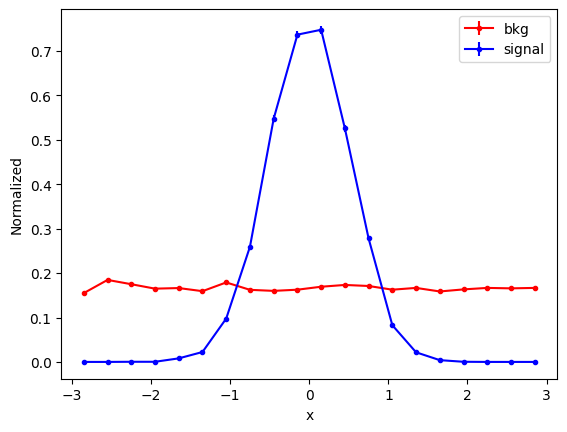

/Users/philipharris/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_base.py:2532: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


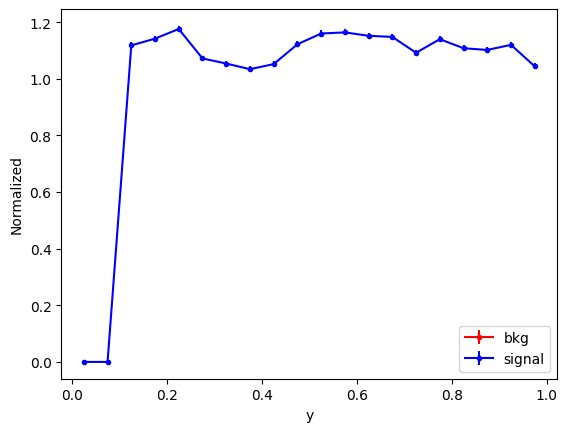

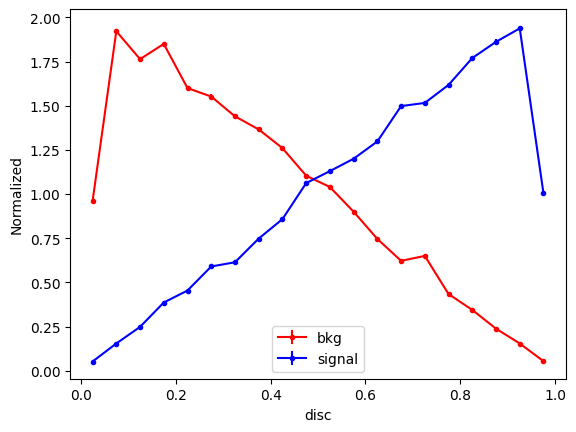

In [377]:
def plotHist(iSig,iBkg,iMin=-3,iMax=3,label="x"):
    ns=len(iSig)
    nb=len(iBkg)
    ys, bin_edges = np.histogram(iSig,density=True,bins=20,range=[iMin,iMax])#bins=bin_edges
    yb, bin_edges = np.histogram(iBkg, bins=bin_edges,density=True)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers,yb,yerr=(nb*yb)**0.5/nb,marker='.',linestyle = '-', color = 'red',label='bkg')
    plt.errorbar(bin_centers,ys,yerr=(ns*ys)**0.5/ns,marker='.',linestyle = '-', color = 'blue',label='signal')
    plt.xlabel(label)
    plt.ylabel("Normalized")
    plt.legend()
    plt.show()

def plotHistComp(iSig,iBkg,iGSig,iGBkg,iMin=-3,iMax=3):
    ns=len(iSig)
    nb=len(iBkg)
    ngs=len(iGSig)
    ngb=len(iGBkg)
    ys, bin_edges = np.histogram(iSig,density=True,bins=20,range=[iMin,iMax])#bins=bin_edges
    yb, bin_edges = np.histogram(iBkg, bins=bin_edges,density=True)
    ygs,bin_edges = np.histogram(iGSig, bins=bin_edges,density=True)
    ygb,bin_edges = np.histogram(iGBkg, bins=bin_edges,density=True)
    ygs*=len(iGSig)/len(iSig)
    ygb*=len(iGBkg)/len(iBkg)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers,yb,yerr=(nb*yb)**0.5/nb,marker='.',linestyle = '-', color = 'red',label='bkg')
    plt.errorbar(bin_centers,ys,yerr=(ns*ys)**0.5/ns,marker='.',linestyle = '-', color = 'blue',label='signal')
    plt.errorbar(bin_centers,ygb,yerr=(ngb/nb)*((ngb*ygb)**0.5)/ngb,marker='.',linestyle = '--', color = 'red',label='bkg(no cuts)')
    plt.errorbar(bin_centers,ygs,yerr=(ngs/ns)*((ngs*ygs)**0.5)/ngs,marker='.',linestyle = '--', color = 'blue',label='signal(no cuts)')
    plt.xlabel("x")
    plt.ylabel("Normalized")
    plt.legend()
    plt.show()
    
def genData(iNS,iNB):
    sx=np.random.normal(0,0.5,iNS)
    sy=np.random.uniform(0.1,1,iNS)
    sz=np.random.triangular(0.,0.95, 1, iNS)
    s=np.vstack([sx,sy,sz])
    
    bx=np.random.uniform(-3,3,iNB)
    by=np.random.uniform(-1,-0.1,iNB)
    bz=np.random.triangular(0,0.05,1,iNB)
    b=np.vstack([bx,by,bz])
    return s,b

sig,bkg=genData(10000,10000)
plotHist(sig[0],bkg[0],label="x")
plotHist(sig[1],bkg[1],0,1,label="y")
plotHist(sig[2],bkg[2],0,1,label="disc")

Now lets do a quick check of the significance calculation, we will use lmfit

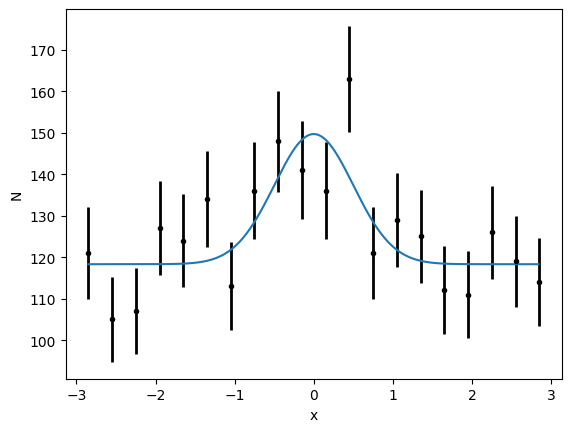

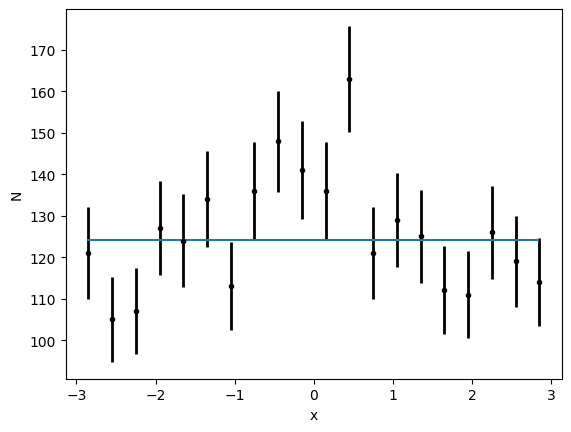

Delta negative Log Likelihood: 15.053340338557216
Our Probability of this happening 0.00010451512543696584
Expected Sig: 3.879863443287423 expected lim: 20.288238547013155 events 130.96855009945793 events 55 sig events
Expected Limit: 12.428232587365557 events Best fit: 25.268289133127585 events 0 sig events


In [458]:
#now lets find 10% background and fit signal this will be our truth
def cutval(iData, p=0.9):
    datasort=np.sort(iData)
    ndata=len(datasort)
    return datasort[int(ndata*p)]


def makeCutDataHist(iD,iVar,iPlot=False):
    cut=cutval(iVar)
    data = iD[0][iVar > cut]
    y,  bin_edges = np.histogram(data, bins=20,range=[-3,3])
    x = 0.5*(bin_edges[1:] + bin_edges[:-1])
    if iPlot:
        plt.errorbar(x, y,yerr= y**0.5,marker='.',linestyle = 'None', color = 'black')
        plt.xlabel("x")
        plt.ylabel("N")
        plt.legend()
        plt.show()
    return x,y,cut

def fitData(iX,iY,iFunc,iSig=False,iAmpVal=0,iPlot=False):
    lFit   = lmfit.Model(iFunc)
    params = lmfit.Parameters()
    params.add('c',    value=125,min=0,max=np.inf)
    params.add('mu',   value=0,min=-3,max=3)
    params.add('sigma',value=0.5,min=0,max=2)
    params.add('amp',  value=0,min=-np.inf,max=np.inf)
    params["mu"].vary = False
    params["sigma"].vary = False
    if not iSig:
        params["amp"].value = iAmpVal
        params["amp"].vary  = False
    iY = np.maximum(iY,1e-5)
    result = lFit.fit(iY,params,x=iX,weights=1./np.sqrt(iY))
    #lmfit.report_fit(result)
    if iPlot:
        #Now we plot it. 
        plt.errorbar(iX, iY,np.sqrt(iY), lw=2,fmt=".k", capsize=0)
        plt.plot(np.arange(iX[0],iX[-1],0.01),iFunc(np.arange(iX[0],iX[-1],0.01),
                                                    result.params['mu'],result.params['sigma'],result.params['amp'],result.params['c']))
        plt.xlabel("x")
        plt.ylabel("N")
        plt.show()
    return result.chisqr,result.params

def fNull(x,mu,sigma,amp,c):
    val = stats.norm.pdf(x,mu,sigma)
    return amp*val + c

def deltaNLL(x,y,iPlot=False):
    LLNull,_=fitData(x,y,fNull,True,0,iPlot)
    LLAlt,_=fitData(x,y,fNull,False,0,iPlot)
    return LLAlt-LLNull

def expLim(x,y,iPlot=False):
    _,params=fitData(x,y,fNull,True,0,iPlot)
    try: 
        ampvalue=params['amp'].stderr
        bestfit=params['amp'].value
    except ValueError:
        ampvalue=0.
        bestfit=0.
    xscale=np.array([])
    amparr=np.array([])
    LLNull,params=fitData(x,y,fNull,False,bestfit,iPlot)
    for pScale in np.arange(0.5,10,0.5):
        #try: 
        LLAlt0,_=fitData(x,y,fNull,False,bestfit+float(ampvalue)*pScale,iPlot)
        #except TypeError:
        #    LLAlt0=0
        #print("dChi2:",LLAlt0-LLNull)
        if LLAlt0 > LLNull:
            xscale=np.append(xscale,ampvalue*pScale)
            amparr=np.append(amparr,LLAlt0-LLNull)
    nllf = interpolate.make_interp_spline(amparr,xscale)
    if iPlot:
        plt.plot(amparr,xscale)
        plt.show()
    return nllf(4),bestfit*3.33

def significance(iX,iY,iPrint=False,iPlot=False):
    NLL = deltaNLL(iX,iY,iPlot)
    p   = 1-stats.chi2.cdf(NLL, 1)
    z   = -1*stats.norm.ppf(p/2.)
    if iPrint:
        print("Delta negative Log Likelihood:",NLL)
        print("Our Probability of this happening",p)
    return z

def asymlimit(iS,iB):
    tdata = np.hstack((iS,iB))
    xcut,ycut,cut=makeCutDataHist(tdata,tdata[2,:])
    lim,amp=expLim(xcut,ycut,False)
    sig=iS[0,iS[2,:] > cut]
    return lim,amp,len(sig)
    
def expSigToy(iS,iB,iDebug=False): #No testing and training needed
    tdata = np.hstack((iS,iB))
    xcut,ycut,cut=makeCutDataHist(tdata,tdata[2,:])
    lim,amp=expLim(xcut,ycut,False)
    sig=iS[0,iS[2,:] > cut]
    #sig1=tdata[1,tdata[2,:] > cut]
    #sig1=sig1[sig1 > 0]
    return significance(xcut,ycut,iDebug,iDebug),lim,amp,len(sig)

#Quick test
pS,pB = genData(125,25000)
pVExpSig,pVLim,pAmp,pSig=expSigToy(pS,pB,True)
print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events",pAmp,"events",pSig,"sig events")
pS,pB = genData(0,10000)
pVLim0,pAmp,pSig = asymlimit(pS,pB)         
print("Expected Limit:",pVLim0,"events","Best fit:",pAmp,"events",pSig,"sig events")

Now that we our significance setting procedure, lets go ahead and build the deep learning algorithm for training so that we can see what is going on. Let's do the usual pytorch setup for training, and run a quick check that it is working.  

simple_MLP_onelayer(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (loss): BCELoss()
  (output): Sigmoid()
)


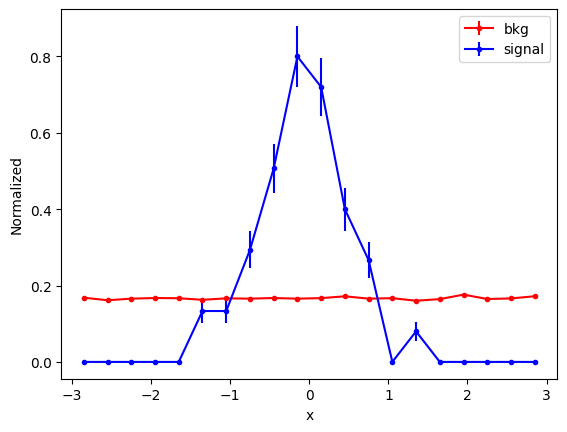

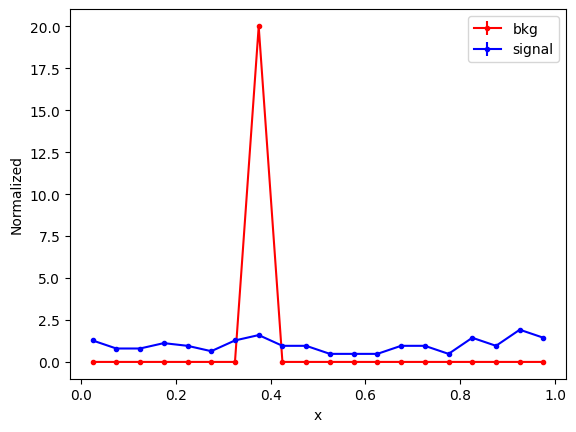

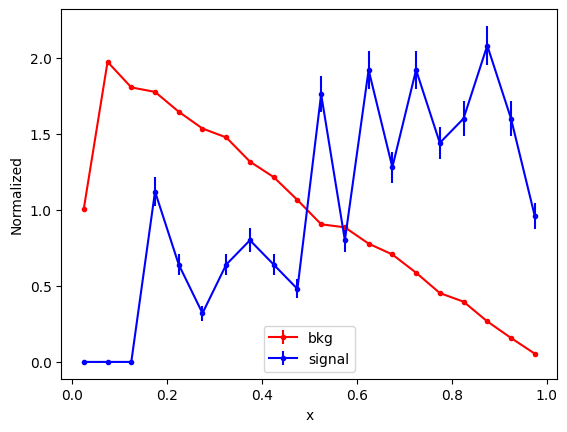

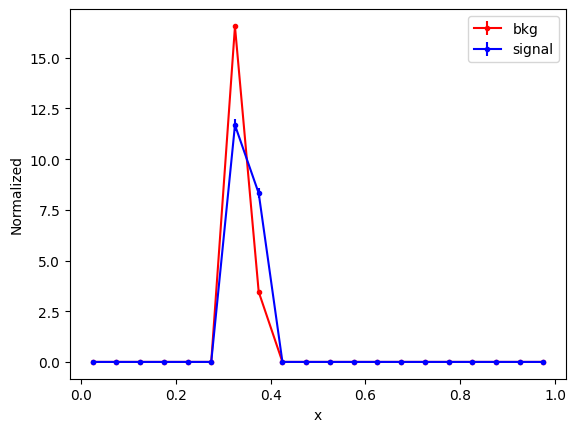

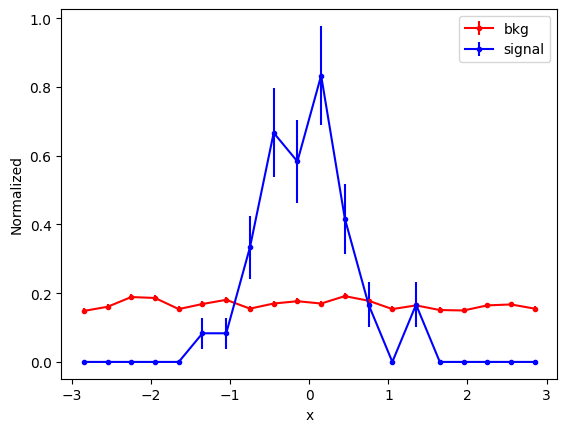

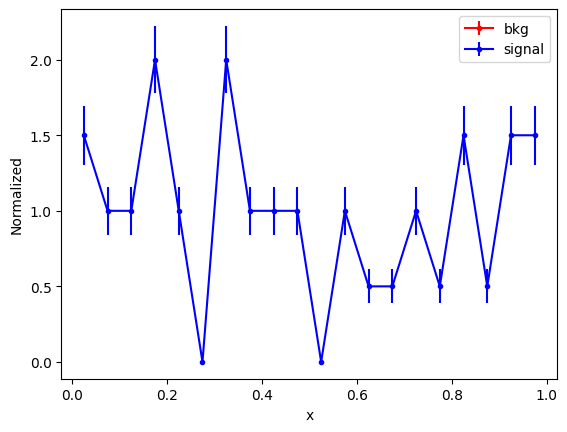

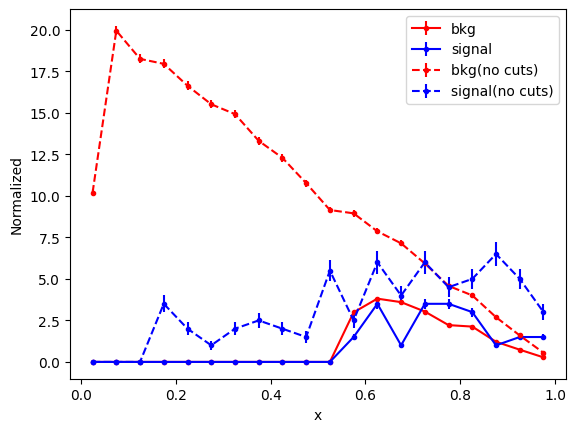

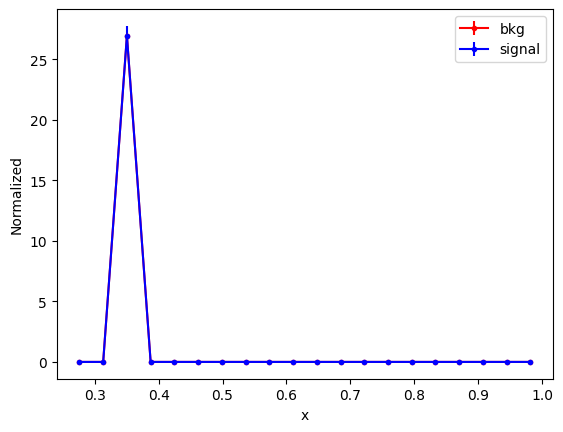

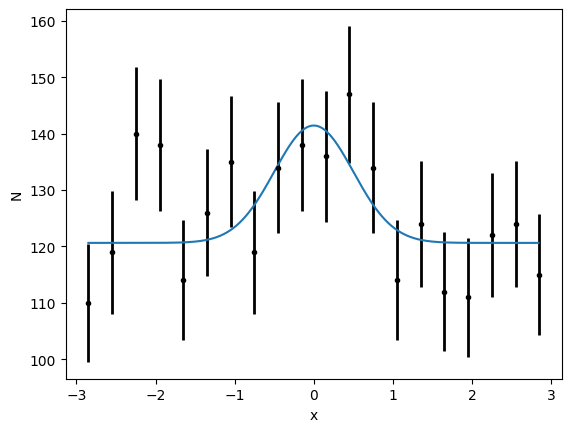

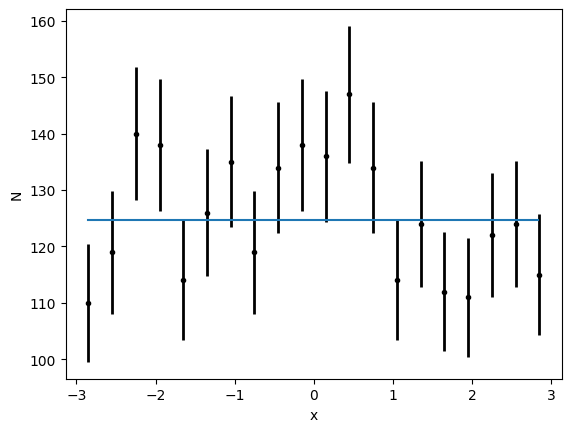

Delta negative Log Likelihood: 6.769732911370571
Our Probability of this happening 0.009271670938781229
Expected Sig: 2.6018710404957752 expected lim: 20.06505232975604 events


In [411]:
from torchsummary import summary

def plotHistComp(iSig,iBkg,iGSig,iGBkg,iMin=-3,iMax=3):
    ns=len(iSig)
    nb=len(iBkg)
    ngs=len(iGSig)
    ngb=len(iGBkg)
    ys, bin_edges = np.histogram(iSig,density=True,bins=20,range=[iMin,iMax])#bins=bin_edges
    yb, bin_edges = np.histogram(iBkg, bins=bin_edges,density=True)
    ygs,bin_edges = np.histogram(iGSig, bins=bin_edges,density=True)
    ygb,bin_edges = np.histogram(iGBkg, bins=bin_edges,density=True)
    ygs*=len(iGSig)/len(iSig)
    ygb*=len(iGBkg)/len(iBkg)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers,yb,yerr=(nb*yb)**0.5/nb,marker='.',linestyle = '-', color = 'red',label='bkg')
    plt.errorbar(bin_centers,ys,yerr=(ns*ys)**0.5/ns,marker='.',linestyle = '-', color = 'blue',label='signal')
    plt.errorbar(bin_centers,ygb,yerr=(ngb/nb)*((ngb*ygb)**0.5)/ngb,marker='.',linestyle = '--', color = 'red',label='bkg(no cuts)')
    plt.errorbar(bin_centers,ygs,yerr=(ngs/ns)*((ngs*ygs)**0.5)/ngs,marker='.',linestyle = '--', color = 'blue',label='signal(no cuts)')
    plt.xlabel("x")
    plt.ylabel("Normalized")
    plt.legend()
    plt.show()
    
def plotDisc(iData,iOutput,iNSP,iNBP,iNSF,iNBF): #all the inputs for splitting data appropriately
    pSigData = torch.cat((iData  [0:iNSP],        iData  [iNSP+iNBP:iNSP+iNBP+iNSF]))
    pBkgData = torch.cat((iData  [iNSP:iNSP+iNBP],iData  [iNSP+iNBP+iNSF:-1]))
    pSigDisc = torch.cat((iOutput[0:iNSP],        iOutput[iNSP+iNBP:iNSP+iNBP+iNSF]))
    pBkgDisc = torch.cat((iOutput[iNSP:iNBP+iNSP],iOutput[iNSP+iNBP+iNSF:-1]))
    plotHist(pSigData[:,0],pBkgData[:,0],-3,3)
    plotHist(pSigData[:,1],pBkgData[:,1],0,1)
    plotHist(pSigData[:,2],pBkgData[:,2],0,1)
    plotHist(pSigDisc,pBkgDisc,0,1)
    cut=cutval(iOutput,p=0.9)
    cutsig = pSigDisc > cut
    cutbkg = pBkgDisc > cut
    plotHist(pSigData[cutsig][:,0],pBkgData[cutbkg][:,0],-3,3)
    plotHist(pSigData[cutsig][:,1],pBkgData[cutbkg][:,1],0,1)
    plotHistComp(pSigData[cutsig][:,2],pBkgData[cutbkg][:,2],pSigData[:,2],pBkgData[:,2],0,1)
    plotHist(pSigDisc[cutsig],pBkgDisc[cutbkg],cut-0.1,1.0)

class DataSet(Dataset):
    def __init__(self, samples, labels):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        return x, y

class simple_MLP_onelayer(torch.nn.Module):
    def __init__(self,in_data,input_size,out_channels=1,act_out=True,nhidden=8,batchnorm=False,batch_size=100,n_epochs=50):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            #nn.Linear(nhidden, nhidden),
            #nn.ReLU(),
            nn.Linear(nhidden, out_channels),
        )
        self.loss    = nn.BCELoss()
        self.output  = torch.nn.Sigmoid()
        self.act_out = act_out
        self.batch_size = batch_size
        self.n_epochs     = n_epochs
        self.opt     = torch.optim.Adam(self.model.parameters(),lr=0.001)
        self.dataloader = DataLoader(in_data, batch_size=self.batch_size, shuffle=True)#,pin_memory=True)
        
    def forward(self, x):
        x = self.model(x)        
        if self.act_out:
            x = self.output(x)
        return x
    
    def training_mse_epoch(self):
        running_loss = 0.0
        updates=0
        for batch_idx, (x, y) in enumerate(self.dataloader):
            self.opt.zero_grad()
            #x     = x.cuda(); y = y.cuda()
            x = x.reshape((len(x),1))
            x_out = self.forward(x)
            loss  = self.loss(x_out.flatten(), y.flatten())
            loss.backward()
            #if batch_idx == 0: 
            #    print(batch_idx, x_out[0:10],x[0:10],y[0:10])
            #    print(loss)
            self.opt.step()
            running_loss += loss 
            updates = updates+1
        return running_loss/updates

    def training_mse(self):
        for epoch in range(self.n_epochs):
            self.model.train(True)
            loss_train = self.training_mse_epoch()
            #print('Epoch: {} LOSS train: {} '.format(epoch,loss_train))

#This sets up our data for training           
def makeDataSet(iD,iNS=1,iNB=1,iMLow=-1,iMHigh=1,iOutTrue=False,iTrueLabel=False):
    #1 is going to be sideband
    #2 is going to be mass range
    pD = iD.T
    dxcutS  = pD[(iD[0] > iMLow) & (iD[0] < iMHigh)]    
    dxcutB  = pD[(iD[0] < iMLow) | (iD[0] > iMHigh)]
    if iTrueLabel:
        dxcutS  = pD[0:iNS]
        dxcutB  = pD[iNS:-1]
    dxcutS  = torch.from_numpy(dxcutS)
    dxcutB  = torch.from_numpy(dxcutB)
    dxcutS  = dxcutS[torch.randperm(len(dxcutS))]
    dxcutB  = dxcutB[torch.randperm(len(dxcutB))]
    #now what we are going to do is split the dataset 
    nS=len(dxcutS)//2
    nB=len(dxcutB)//2
    tot1=torch.cat([dxcutS[0:nS,2],dxcutB[0:nB,2]])
    tot1=tot1.float()
    tot2=torch.cat([dxcutS[nS-1:-1,2],dxcutB[nB-1:-1,2]])
    tot2=tot2.float()
    #now merge sig and bkg and make dataset
    totfull1=torch.cat([dxcutS[0:nS],dxcutB[0:nB]])
    totfull1=totfull1.float()
    totfull2=torch.cat([dxcutS[nS-1:-1],dxcutB[nB-1:-1]])
    totfull2=totfull2.float()
    if iOutTrue:
        tD = torch.from_numpy(pD)
        totfull1=torch.cat([tD[0:iNS//2],tD[iNS:iNS+iNB//2]])
        totfull1=totfull1.float()
        totfull2=torch.cat([tD[iNS//2-1:iNS],tD[iNS+iNB//2-1:-1]])
        totfull2=totfull2.float()
    #now lets make labels
    siglabel1=torch.ones(nS)
    bkglabel1=torch.zeros(nB)
    label1=torch.cat((siglabel1,bkglabel1))
    siglabel2=torch.ones(len(dxcutS)-nS)
    bkglabel2=torch.zeros(len(dxcutB)-nB)
    label2=torch.cat((siglabel2,bkglabel2))
    #training datasets
    datatrain1=DataSet(samples=tot1,labels=label1)
    datatrain2=DataSet(samples=tot2,labels=label2)
    return datatrain1,datatrain2,totfull1,totfull2,nS*2,nB*2,iNS//2,iNB//2,iNS-iNS//2,iNB-iNB//2

#Note to actually be realistic we need to split data into pieces and train and apply
def expSigWeakToy(iS,iB,iPlot=True,iOutTrue=False):
    tdata = np.hstack((iS,iB))
    data1,data2,datafull1,datafull2,nS,nB,nTSP,nTBP,nTSF,nTBF=makeDataSet(tdata,len(iS[0]),len(iB[0]),iOutTrue=iOutTrue)
    #run two trainings
    rw_model0 = simple_MLP_onelayer(data1,1,out_channels=1,act_out=True,batchnorm=False)
    rw_model0.training_mse()
    rw_model1 = simple_MLP_onelayer(data2,1,out_channels=1,act_out=True,batchnorm=False)
    rw_model1.training_mse()
    #no2 inference
    output0=rw_model1.forward(datafull1[:,2].reshape(len(datafull1),1))
    output1=rw_model0.forward(datafull2[:,2].reshape(len(datafull2),1))
    output=torch.cat((output0,output1))
    datafull=torch.cat((datafull1,datafull2))
    xcut,ycut,cut=makeCutDataHist(datafull.T,output.flatten().detach().numpy())
    if iPlot:
        print(rw_model0)
        if iOutTrue:
            plotDisc(datafull,output.flatten().detach(),nTSP,nTBP,nTSF,nTBF)
        else:
            plotDisc(datafull,output.flatten().detach(),nS//2,nB//2,nS//2,nB//2)
    lim,amp=expLim(xcut,ycut,False)
    sigout=output[datafull[:,1] > 0]
    sig=sigout[sigout > cut]
    return significance(xcut,ycut,iPlot,iPlot),lim,amp,len(sig)

nb=25000
#pS,pB = genData(int(0.5*nb),nb)
#pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,True)
#print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

#pS,pB = genData(int(0.05*nb),nb)
#pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,True)
#print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

pS,pB = genData(int(0.005*nb),nb)
pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,True)
print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events",)

#pS,pB = genData(int(0.001*nb),nb)
#pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,True)
#print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

Now importantly we should check how things look with mass sideband trainings

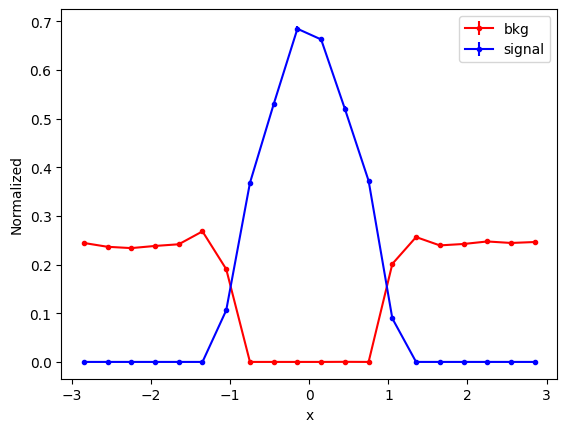

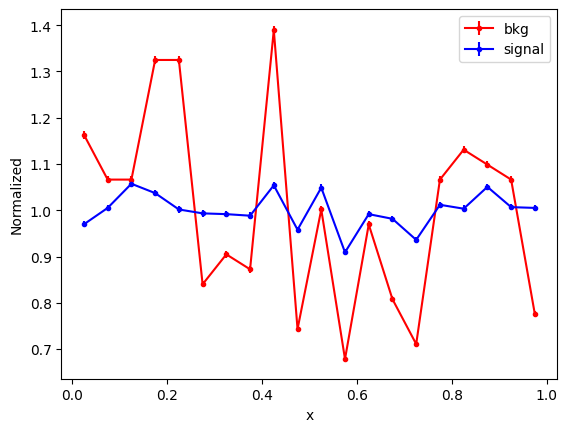

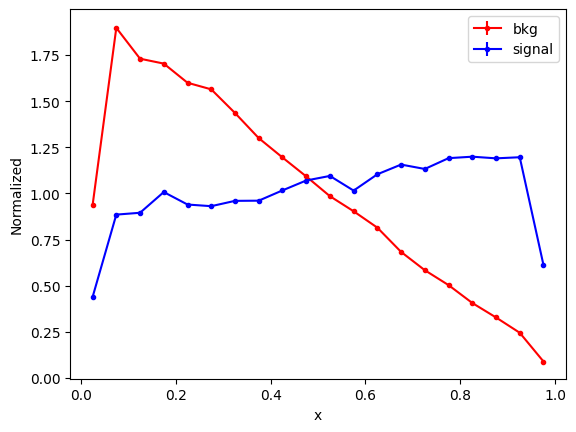

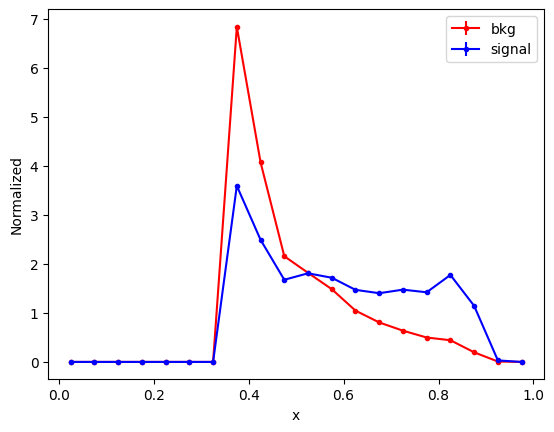

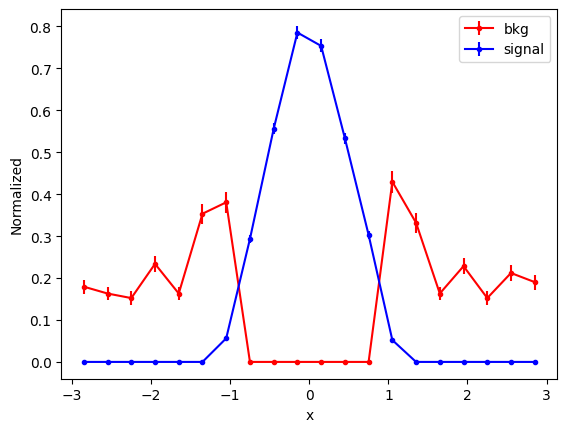

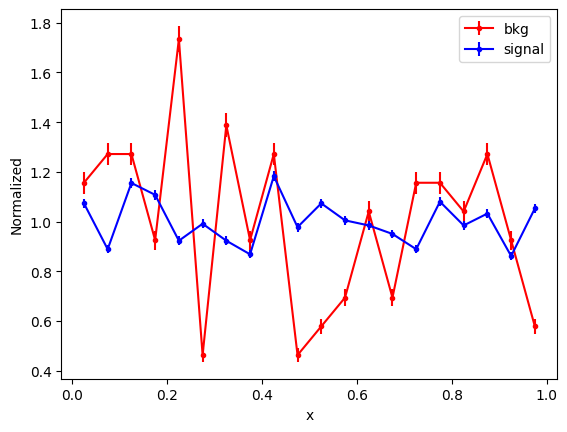

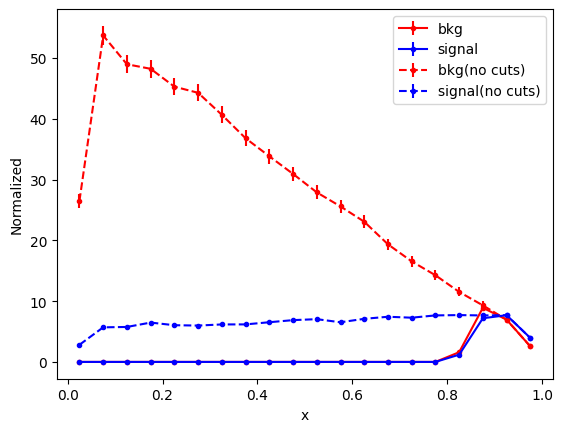

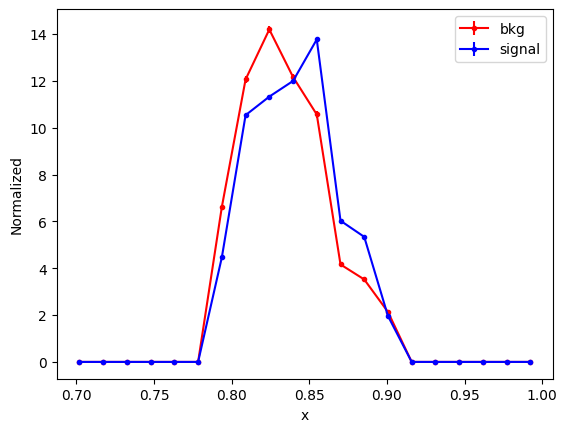

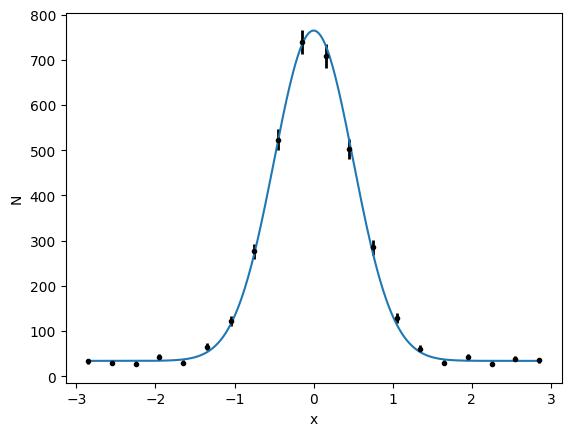

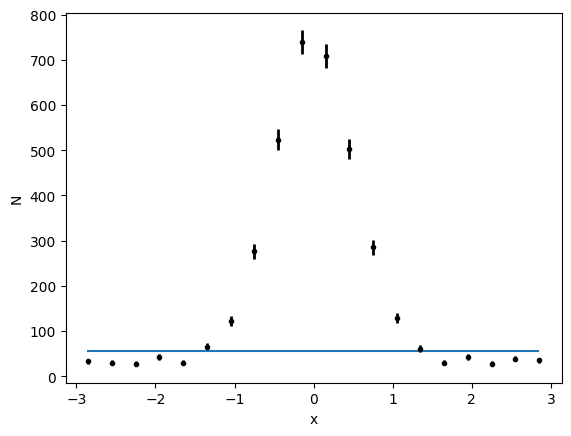

Delta negative Log Likelihood: 2633.795497430334
Our Probability of this happening 0.0
Expected Sig: inf expected lim: 35.69902100847297 events


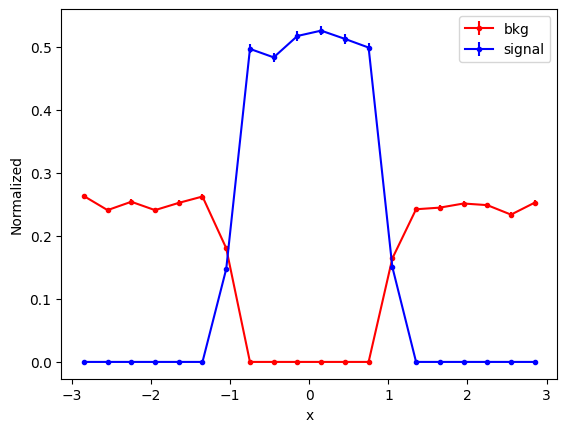

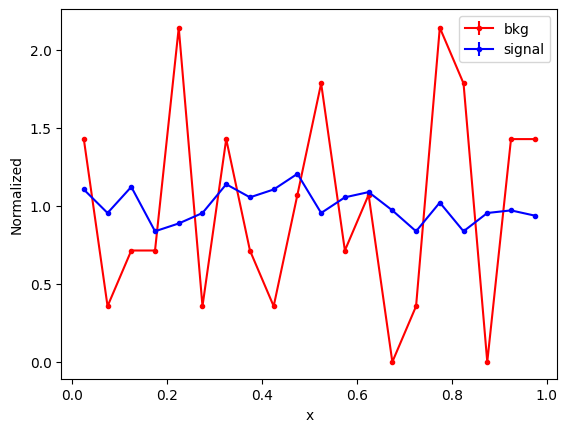

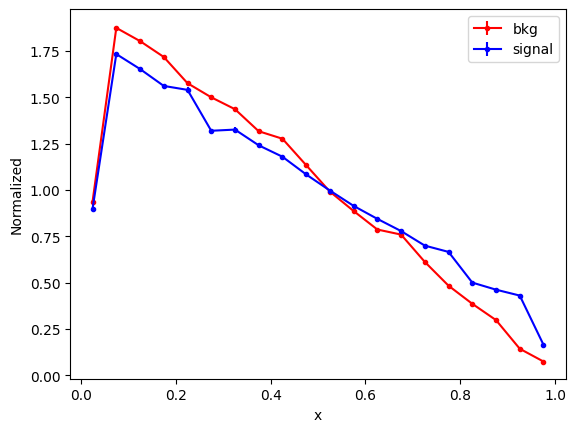

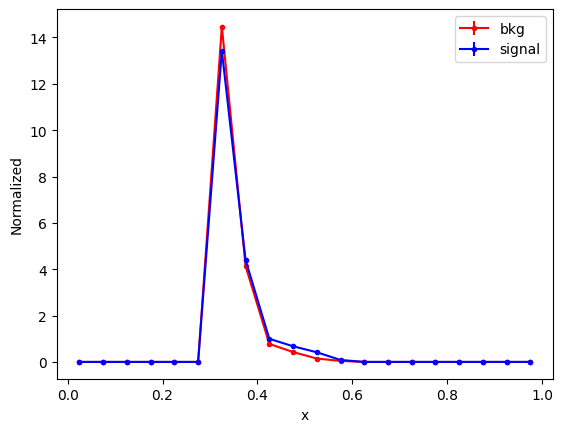

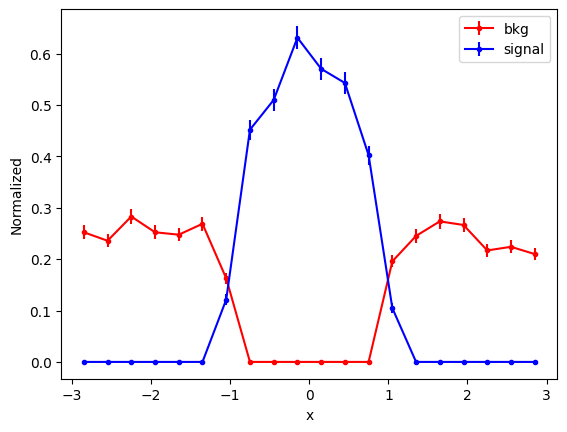

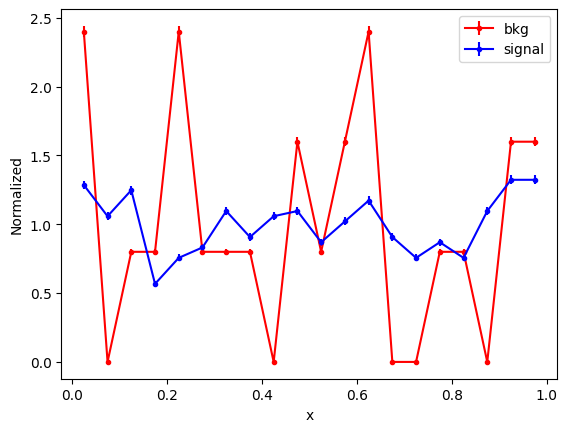

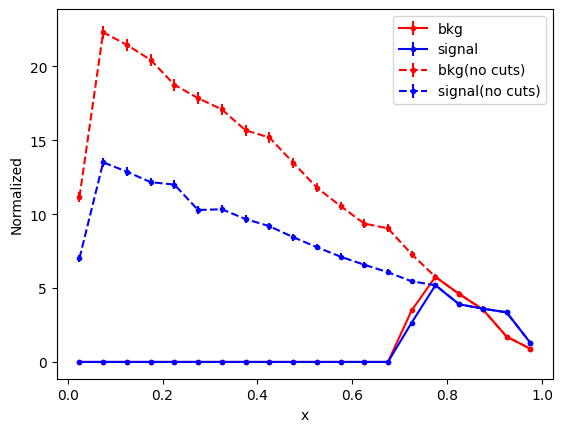

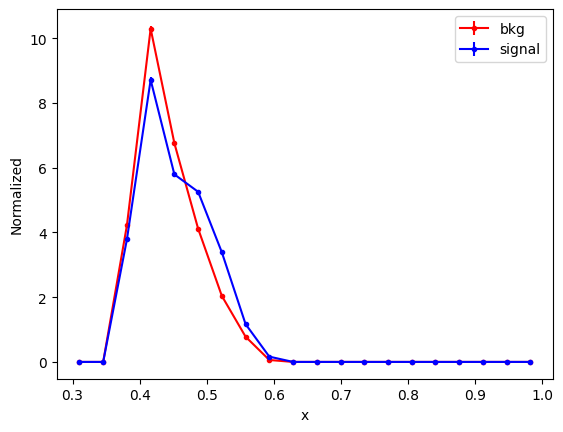

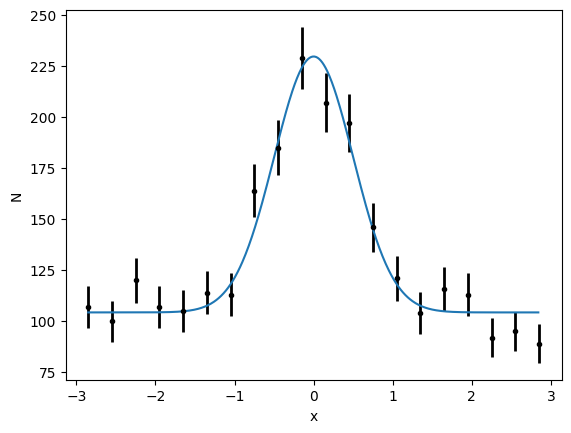

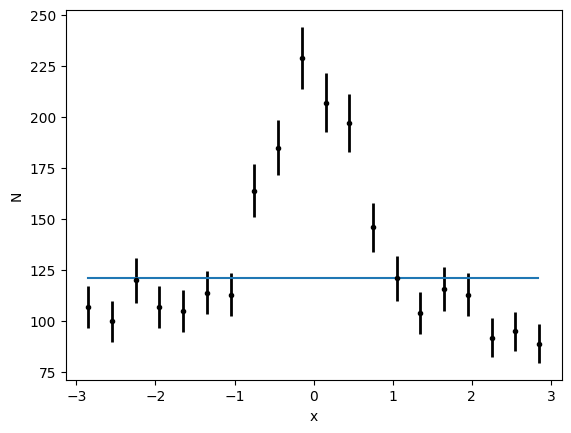

Delta negative Log Likelihood: 182.2227286731684
Our Probability of this happening 0.0
Expected Sig: inf expected lim: 23.29179854804423 events


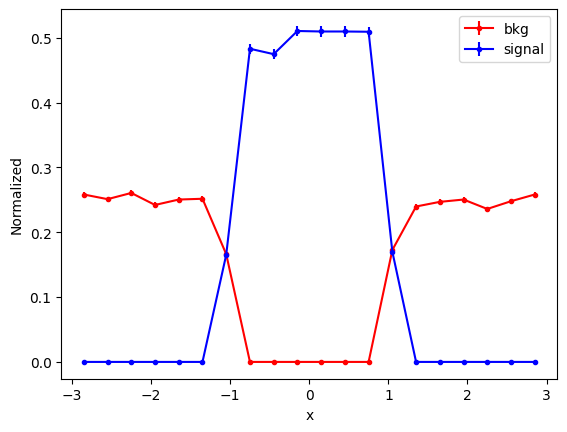

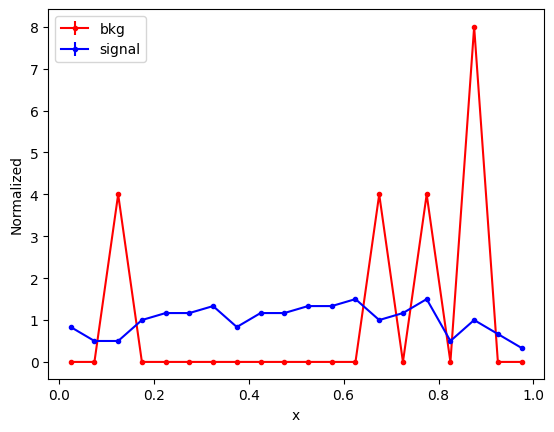

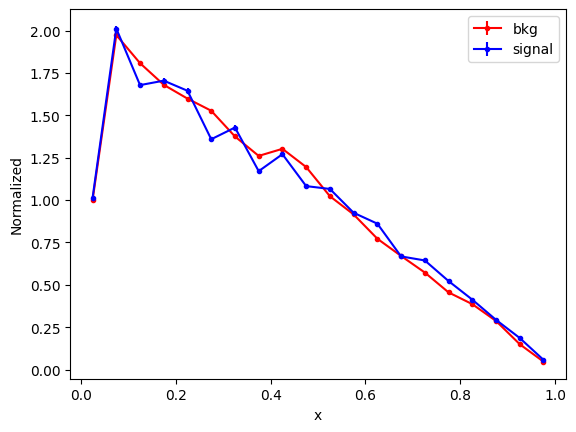

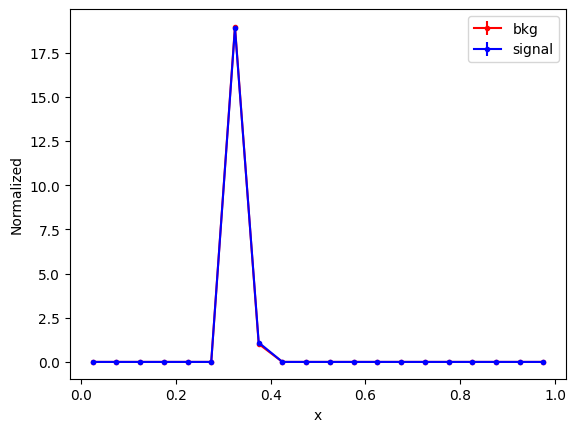

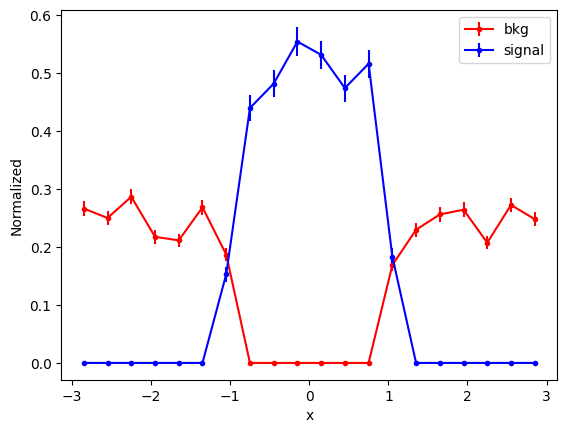

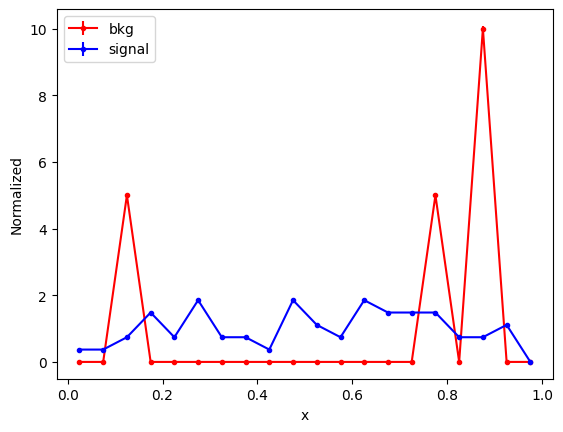

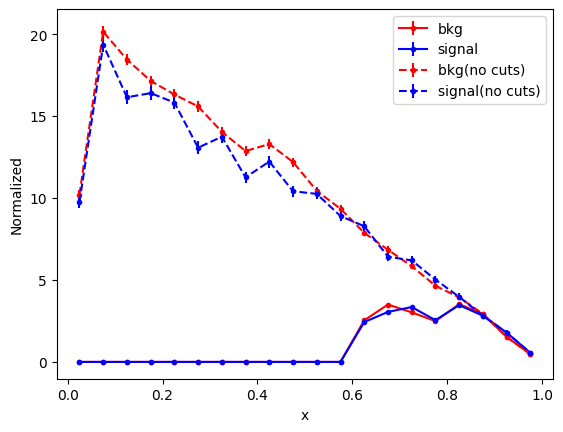

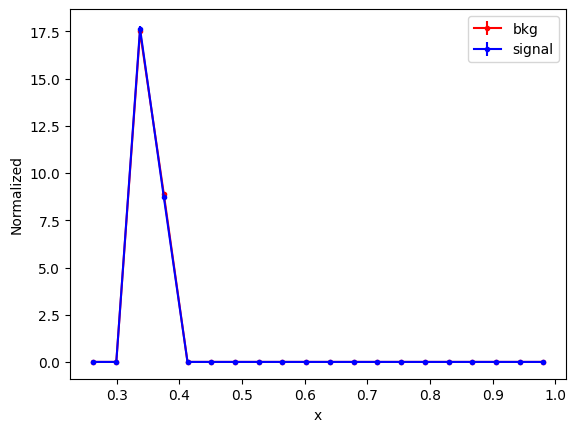

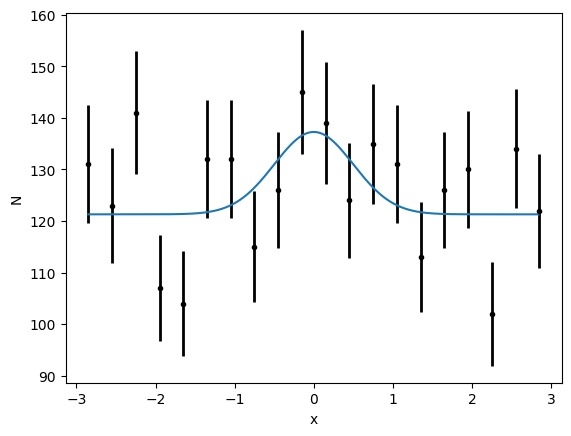

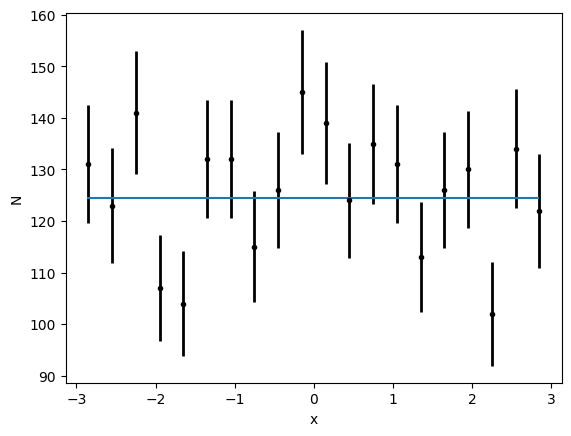

Delta negative Log Likelihood: 4.002378820115549
Our Probability of this happening 0.04543609421023154
Expected Sig: 2.00059461663665 expected lim: 19.9977156585155 events


In [277]:
pS,pB = genData(int(0.5*nb),nb)
pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,False)
print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

pS,pB = genData(int(0.05*nb),nb)
pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,False)
print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

pS,pB = genData(int(0.005*nb),nb)
pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,False)
print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

#pS,pB = genData(int(0.001*nb),nb)
#pVExpSig,pVLim,pVAmp,pVSig=expSigWeakToy(pS,pB,True,False)
#print("Expected Sig:",pVExpSig,"expected lim:",pVLim,"events")

Ok now we have all the tools to run toys and compute limits and vary signals etc... Lets go ahead and start some comparisons of just a simple discriminator vs the NN cut

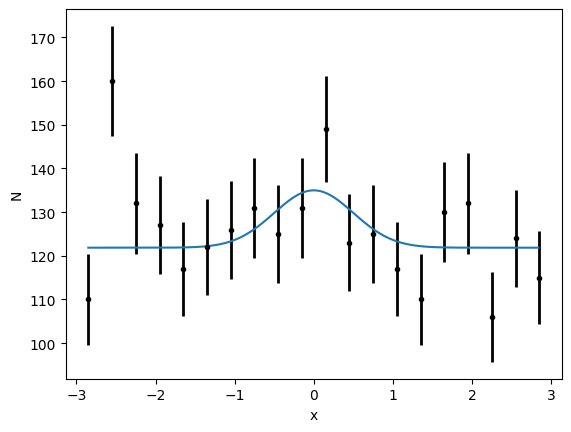

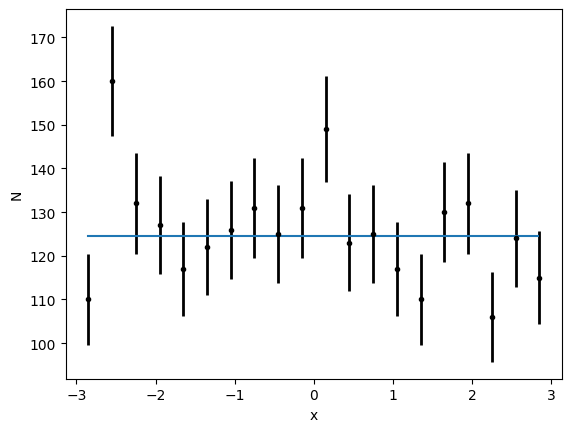

Delta negative Log Likelihood: 2.7276075293198403
Our Probability of this happening 0.0986269297661877


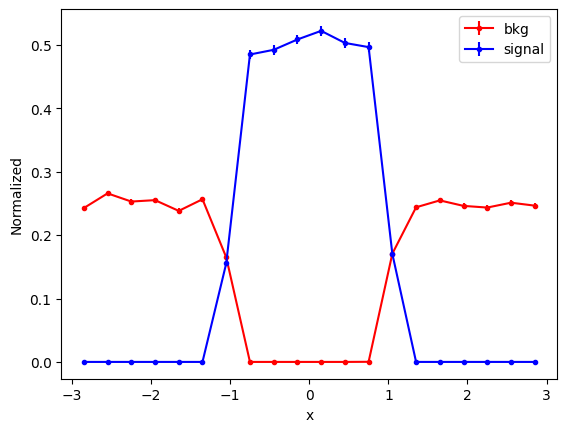

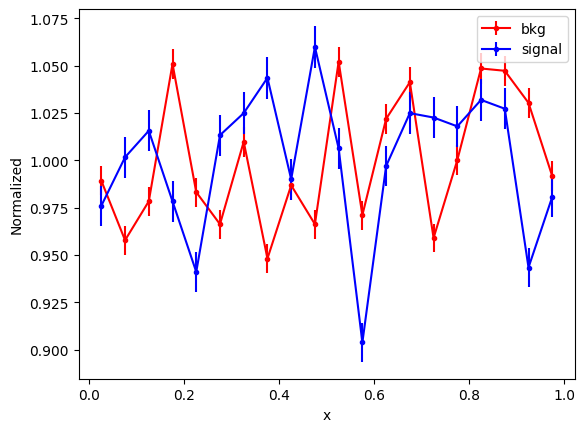

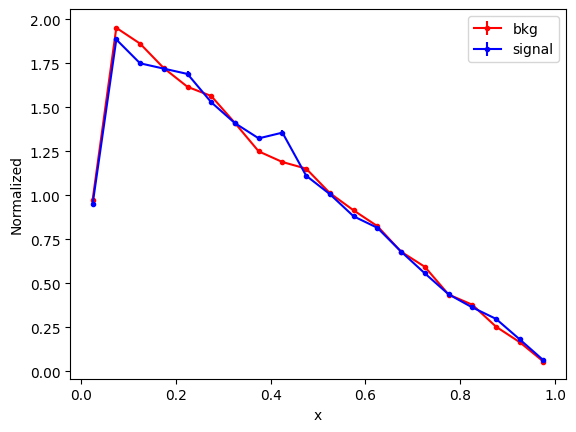

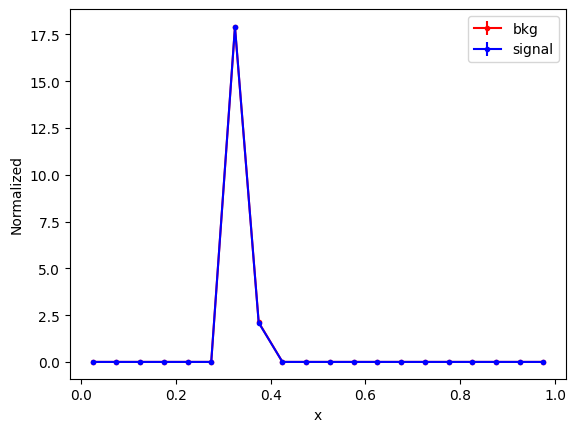

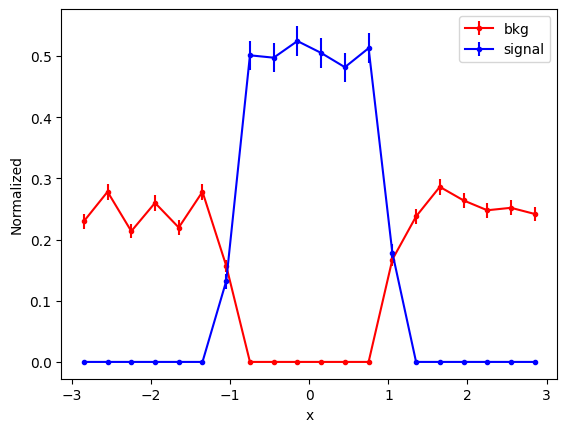

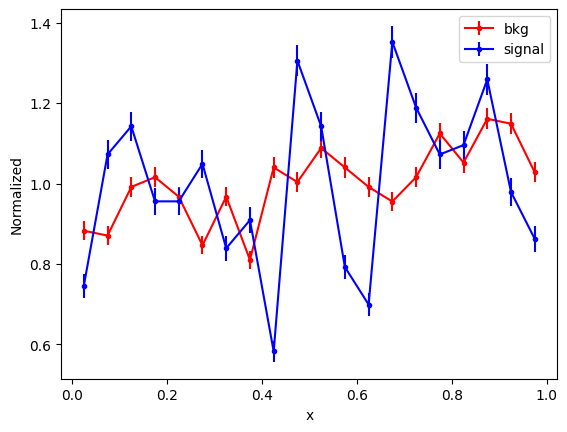

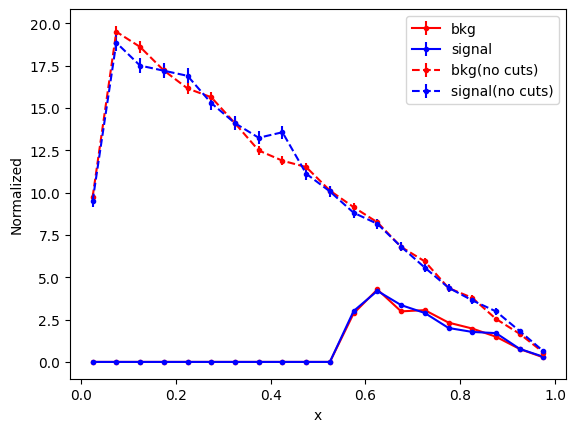

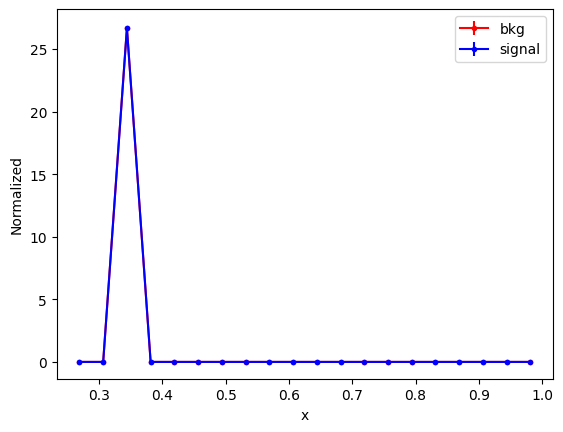

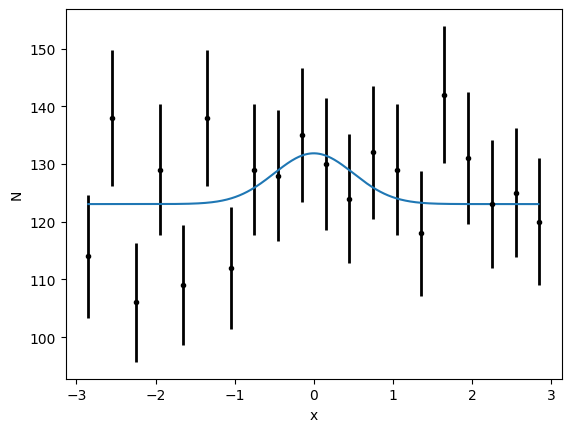

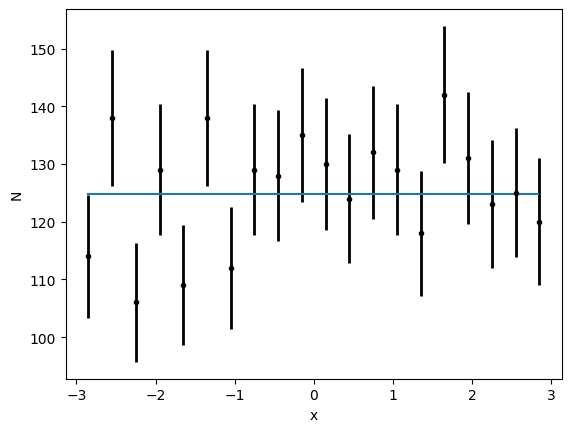

Delta negative Log Likelihood: 1.250720233042502
Our Probability of this happening 0.2634149612572243
Exp sig: 2.7276075293198403 Weak sig: 1.250720233042502
Exp lim: 19.91718916381415 Weak lim: 19.72624583867711


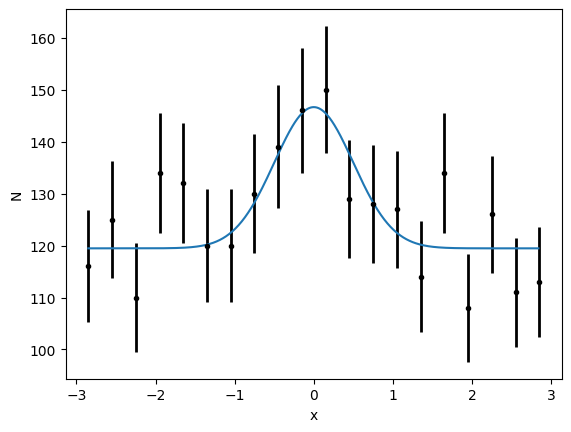

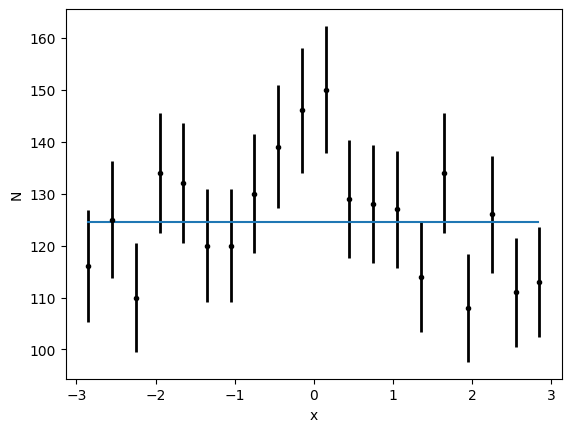

Delta negative Log Likelihood: 11.18434149039423
Our Probability of this happening 0.0008249052738295015


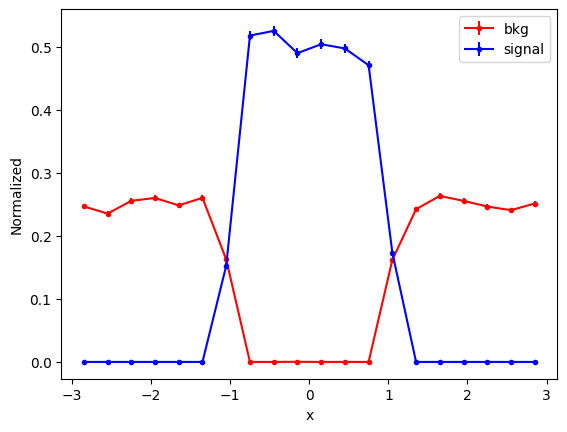

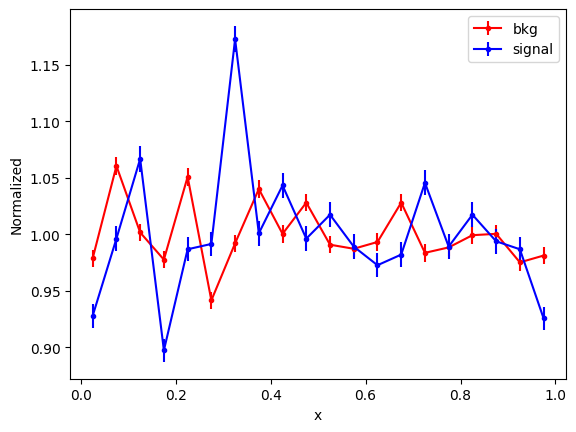

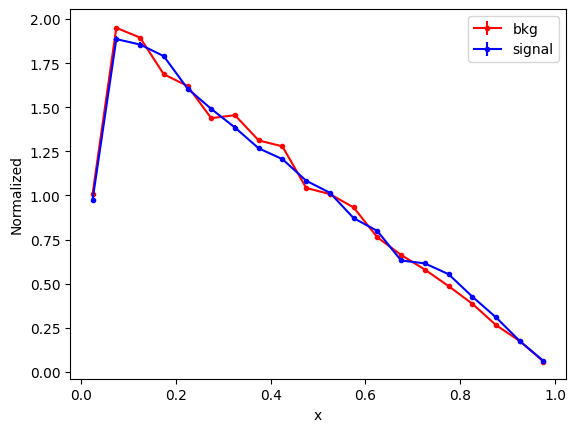

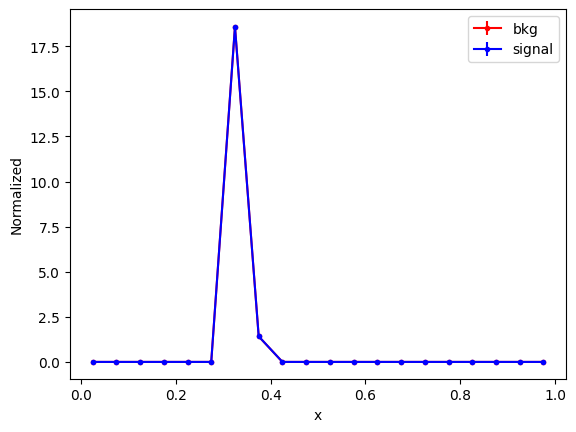

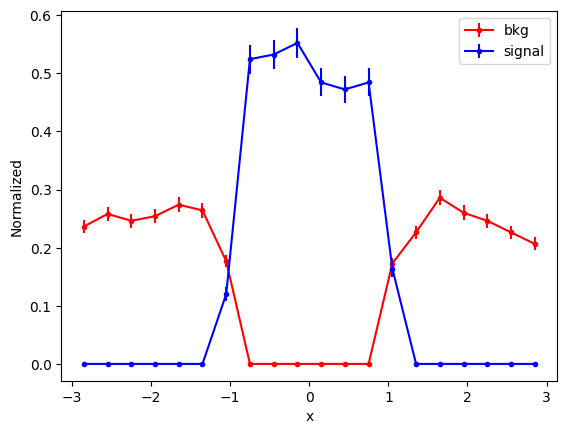

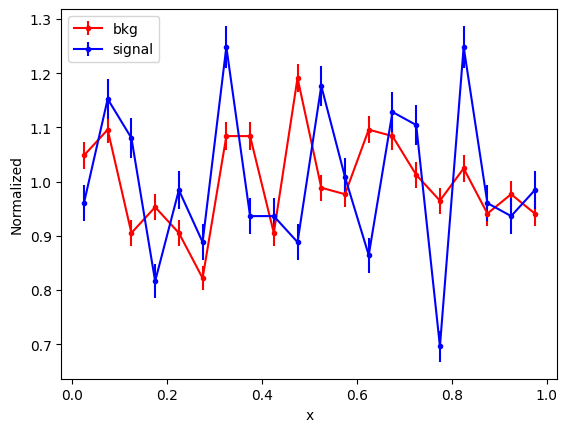

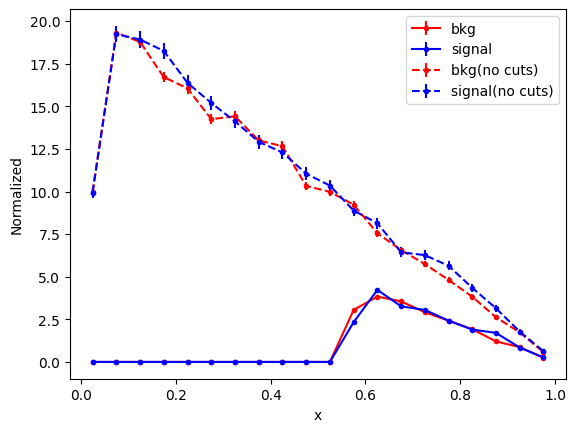

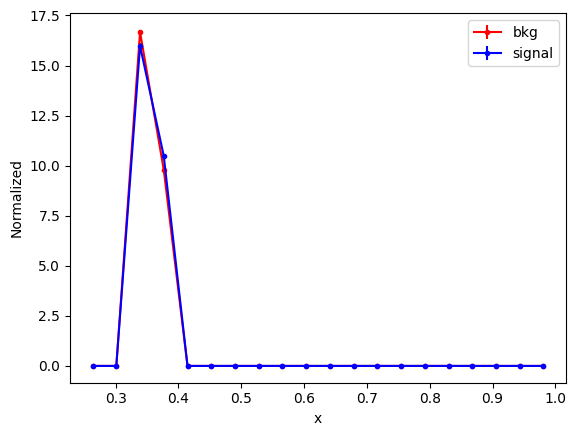

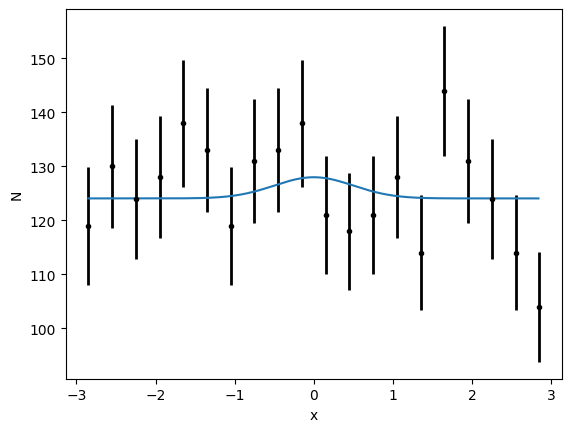

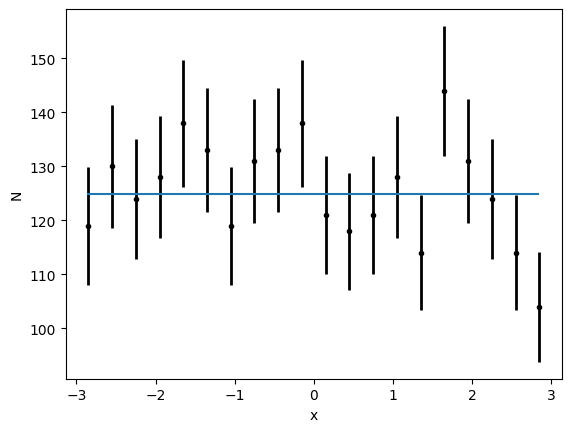

Delta negative Log Likelihood: 0.25199805159375543
Our Probability of this happening 0.6156716885999323
Exp sig: 11.18434149039423 Weak sig: 0.25199805159375543
Exp lim: 20.360867327906096 Weak lim: 19.58692070922877


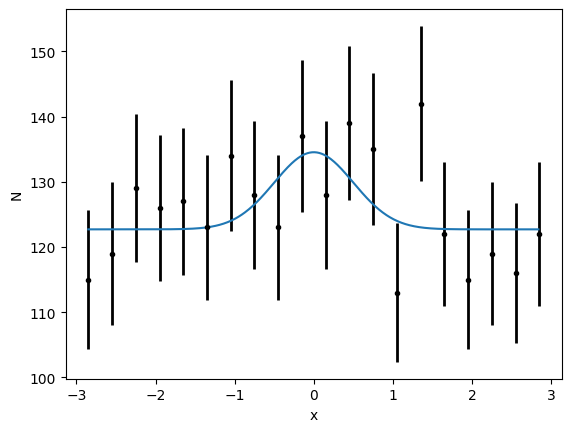

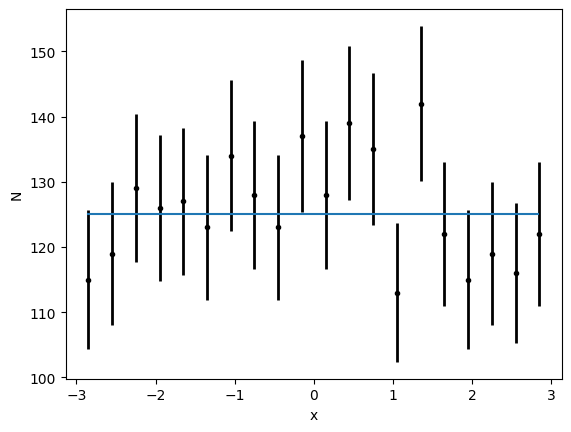

Delta negative Log Likelihood: 2.252365807669401
Our Probability of this happening 0.1334103011222756


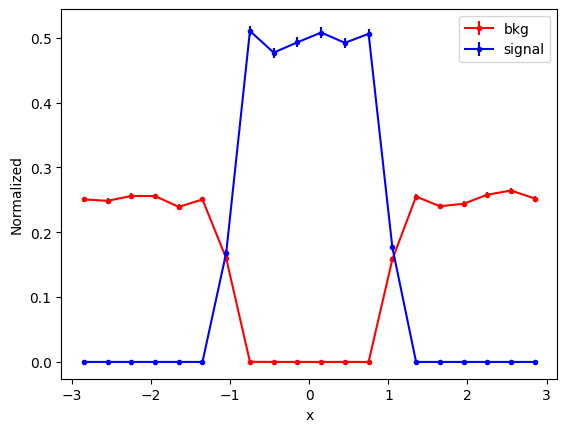

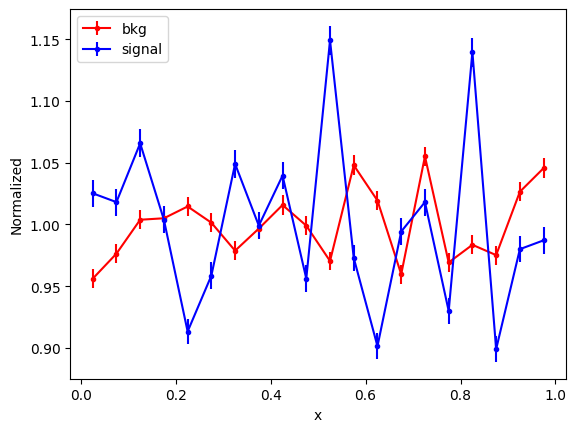

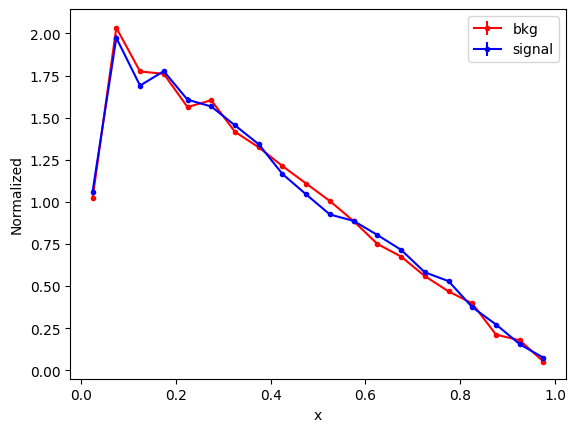

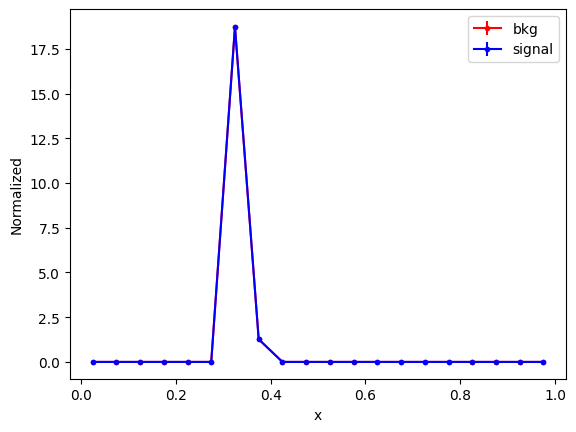

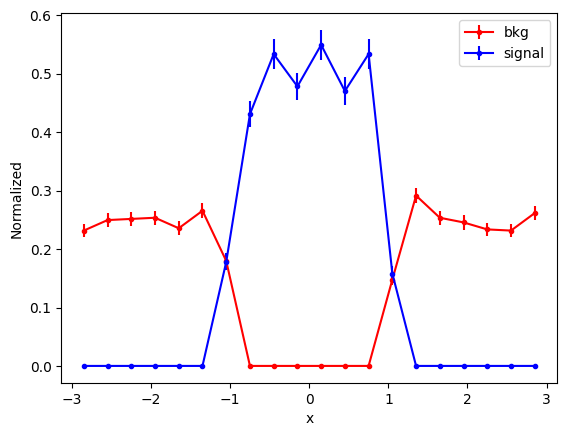

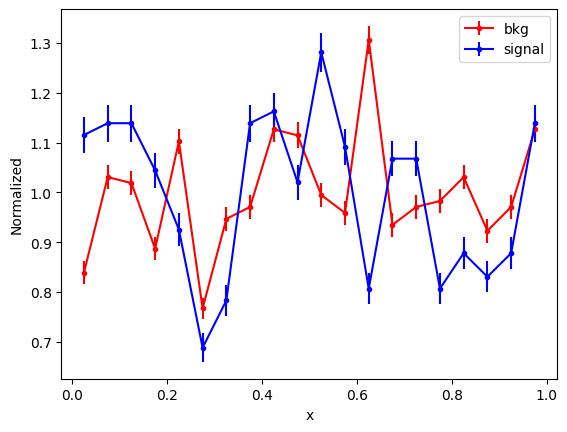

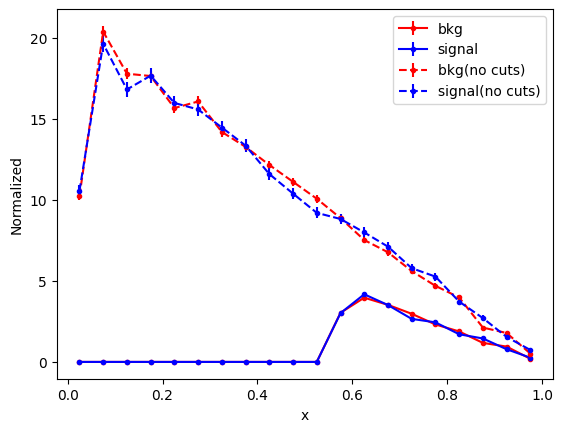

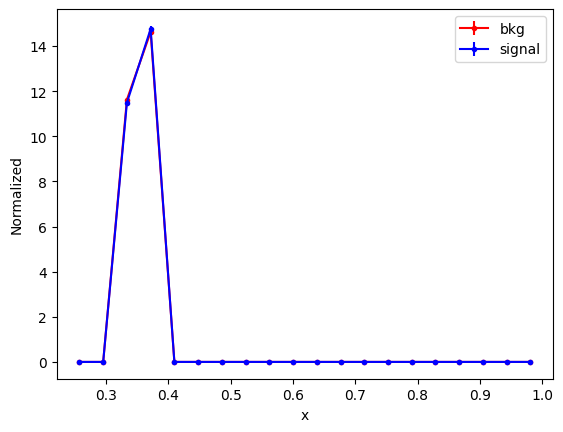

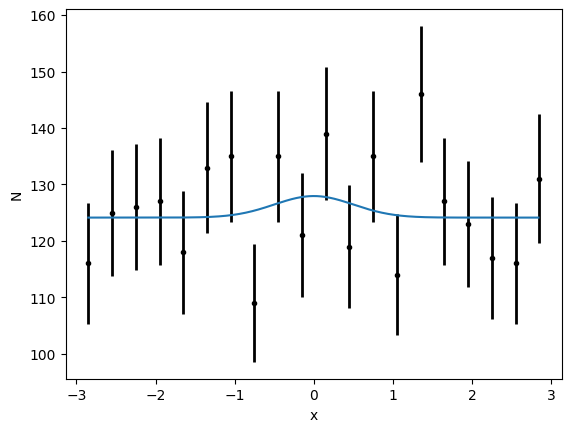

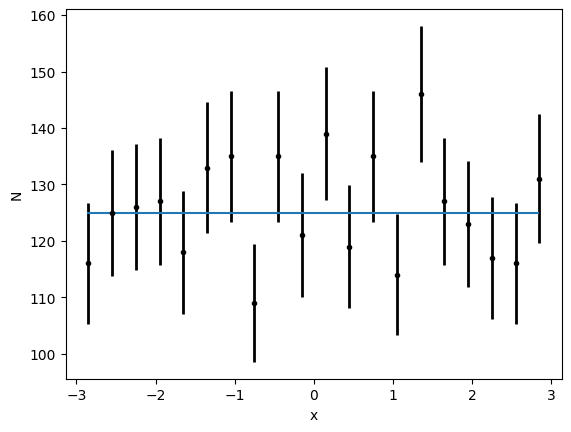

Delta negative Log Likelihood: 0.23791407031367307
Our Probability of this happening 0.6257167589326063
Exp sig: 2.252365807669401 Weak sig: 0.23791407031367307
Exp lim: 19.763296827864735 Weak lim: 19.62240542566598


In [221]:
nb=25000

def printOutput(iNS,iNB):
    pS,pB = genData(iNS,iNB)
    pVExpSig,    pVLim,    pVAmp,pVSig=expSigToy(pS,pB,True)
    pVExpWeakSig,pVWeakLim,pVWeakAmp,pVWeakSig=expSigWeakToy(pS,pB,True)
    print("Exp sig:",pVExpSig,"Weak sig:",pVExpWeakSig)
    print("Exp lim:",pVLim,   "Weak lim:",pVWeakLim)
    
#printOutput(int(0.5*nb),nb)
#printOutput(int(0.05*nb),nb)
#printOutput(int(0.02*nb),nb)
#printOutput(int(0.01*nb),nb)
printOutput(int(0.005*nb),nb)
printOutput(int(0.005*nb),nb)
printOutput(int(0.005*nb),nb)
#printOutput(int(0.001*nb),nb)

Now we can compute a whole stack of toys with this guy to start to make general conclusions. 

Fit: 1.8112958795907712  rms: 0.9264390916037313
Weak: 1.262495153796805  rms: 0.9293474014778543


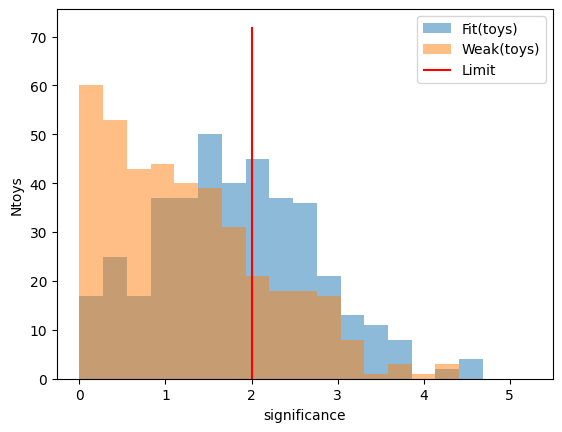

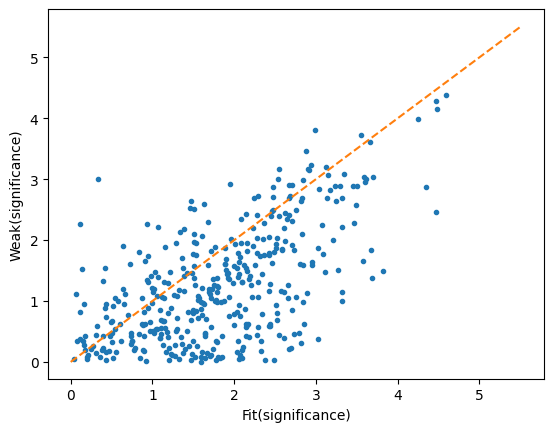

Fit: 66.2009388466856  rms: 0.9245546977497853
Weak: 65.31312737396738  rms: 3.754108318270299


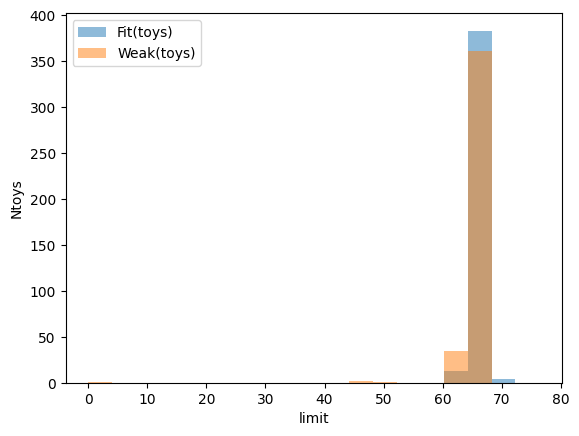

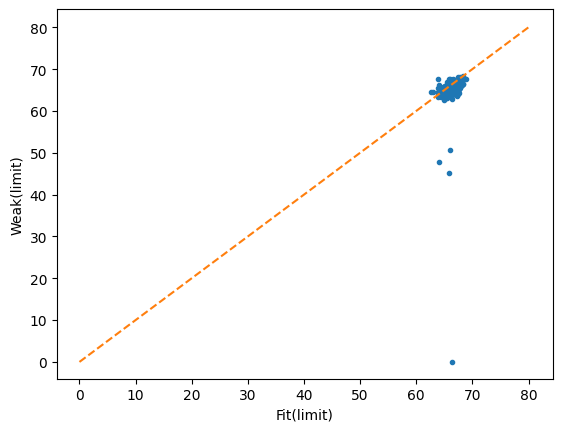

Fit: 59.43474328626286  rms: 33.11845050396013
Weak: 36.25360583263021  rms: 37.52634220071801


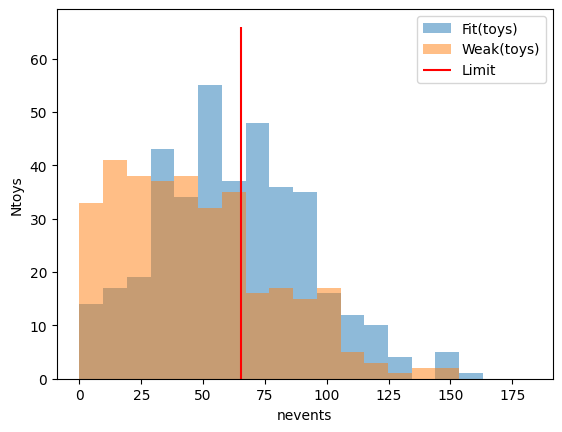

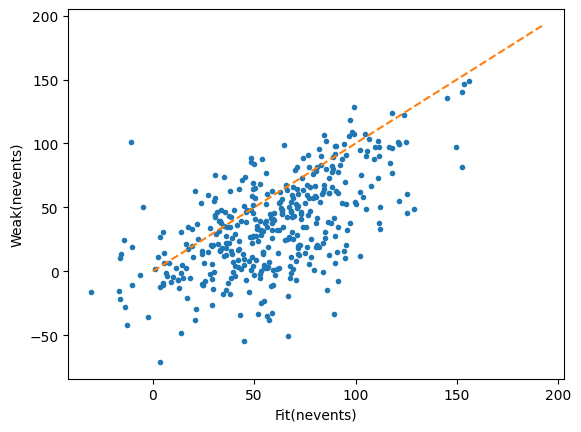

Fit: 61.3225  rms: 5.498499227061871
Weak: 39.4825  rms: 17.709310933799767


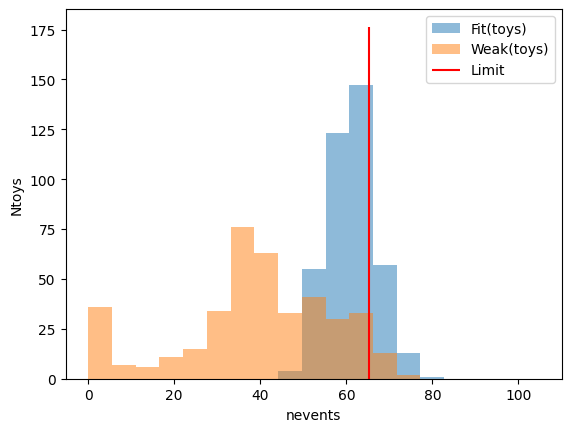

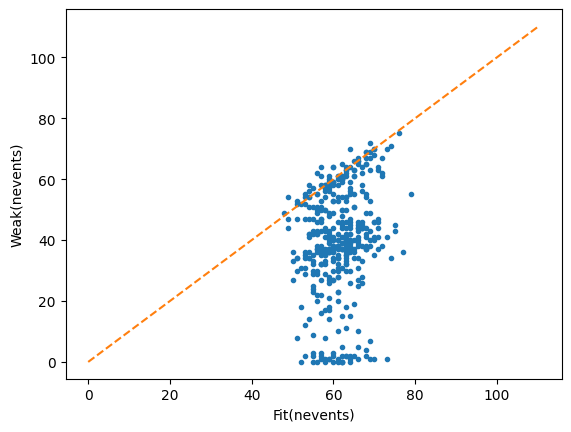

In [449]:
def genData(iNS,iNB):
    sx=np.random.normal(0,0.5,iNS)
    sy=np.random.uniform(0,1,iNS)
    sz=np.random.triangular(0.,0.95, 1, iNS)
    s=np.vstack([sx,sy,sz])
    
    bx=np.random.uniform(-3,3,iNB)
    by=np.random.uniform(-1,0,iNB)
    bz=np.random.triangular(0,0.05,1,iNB)
    b=np.vstack([bx,by,bz])
    return s,b

def plotToyHist(iFit,iWeak,label="x",iScaleMax=5,iLimit=-1):
    print("Fit:",np.mean(iFit),  " rms:",np.std(iFit))
    print("Weak:",np.mean(iWeak)," rms:",np.std(iWeak))
    maxvalueF=np.mean(iFit)+iScaleMax*np.std(iFit)
    maxvalueW=np.mean(iWeak)+iScaleMax*np.std(iWeak)
    maxvalue=np.maximum(maxvalueW,maxvalueF)
    
    bins=np.arange(0,maxvalue,maxvalue/20)
    vals0,_,_=plt.hist(iFit,bins=bins,alpha=0.5,label='Fit(toys)')
    vals1,_,_=plt.hist(iWeak,bins=bins,alpha=0.5,label='Weak(toys)')
    if iLimit > 0:
        vals0=np.max(vals0.flatten())
        vals1=np.max(vals1.flatten())
        plt.vlines(iLimit,0,1.2*np.maximum(vals0,vals1),color='red',label='Limit')
    plt.xlabel(label)
    plt.ylabel("Ntoys")
    plt.legend()
    plt.show()

    xvals=[0,maxvalue]
    plt.plot(iFit,iWeak,'.',label='toys')
    plt.plot(xvals,xvals,'--')
    plt.xlabel("Fit("+label+")")
    plt.ylabel("Weak("+label+")")
    plt.show()


def Toy(iNS,iNB):
    pS,pB = genData(iNS,iNB)
    pVExpSig,    pVLim,    pVAmp,    pVSig=expSigToy(pS,pB,False)
    pVExpWeakSig,pVWeakLim,pVWeakAmp,pVWeakSig=expSigWeakToy(pS,pB,False)
    return pVExpSig,pVExpWeakSig,pVLim,pVWeakLim,pVAmp,pVWeakAmp,pVSig,pVWeakSig

def runToys(iNS,iNB,iNToys):
    expSig=np.array([])
    expWeakSig=np.array([])
    expLim=np.array([])
    expWeakLim=np.array([])
    expAmp=np.array([])
    expWeakAmp=np.array([])
    expNSig=np.array([])
    expWeakNSig=np.array([])
    for pToy in range(iNToys):
        print(pToy)
        pVExpSig,pVExpWeakSig,pVLim,pVWeakLim,pVAmp,pVWeakAmp,pVSig,pVWeakSig=Toy(iNS,iNB)
        expSig=    np.append(expSig,    pVExpSig)
        expWeakSig=np.append(expWeakSig,pVExpWeakSig)
        expLim=    np.append(expLim,    pVLim)
        expWeakLim=np.append(expWeakLim,pVWeakLim)
        expAmp=    np.append(expAmp,    pVAmp)
        expWeakAmp=np.append(expWeakAmp,pVWeakAmp)
        expNSig=    np.append(expNSig,    pVSig)
        expWeakNSig=np.append(expWeakNSig,pVWeakSig)
    return expSig,expWeakSig,expLim,expWeakLim,expAmp,expWeakAmp,expNSig,expWeakNSig
    
nb=25000
ntoys=25

#sigToysTot=np.array([]);  sigWeakToysTot=np.array([]); 
#limToysTot=np.array([]);  limWeakToysTot=np.array([]);
#ampToysTot=np.array([]);  ampWeakToysTot=np.array([]);
#nsigToysTot=np.array([]); nsigWeakToysTot=np.array([]); 
#for n in range(2):
#    sigToys,sigWeakToys,limToys,limWeakToys,ampToys,ampWeakToys,nsigToys,nsigWeakToys=runToys(int(0.005*nb),nb,ntoys)
#    sigToysTot  = np.append(sigToysTot,sigToys); sigWeakToysTot  = np.append(sigWeakToysTot,sigWeakToys); 
#    limToysTot  = np.append(limToysTot,limToys); limWeakToysTot  = np.append(limWeakToysTot,limWeakToys); 
#    ampToysTot  = np.append(ampToysTot,ampToys); ampWeakToysTot  = np.append(ampWeakToysTot,ampWeakToys); 
#    nsigToysTot = np.append(nsigToysTot,nsigToys); nsigWeakToysTot = np.append(nsigWeakToysTot,nsigWeakToys); 

plotToyHist(sigToysTot,sigWeakToysTot,label='significance',iScaleMax=4,iLimit=2.0)
plotToyHist(limToysTot*3.33,limWeakToysTot*3.33,label='limit',iScaleMax=4)
plotToyHist(ampToysTot,ampWeakToysTot,label='nevents',iScaleMax=4,iLimit=np.mean(limWeakToysTot*3.33))
plotToyHist(nsigToysTot,nsigWeakToysTot,label='nevents',iScaleMax=4,iLimit=np.mean(limWeakToysTot*3.33))

#plotToyHist(sigToys,sigWeakToys,label='significance')
#plotToyHist(limToys,limWeakToys,label='limit')
#plotToyHist(ampToys,ampWeakToys,label='nevents')
#plotToyHist(nsigToys,nsigWeakToys,label='nevents')

Now lets consider an alternative scenario where we jus swap the signal to be on the other side, and we cut incorrectly when we do the cut based. 

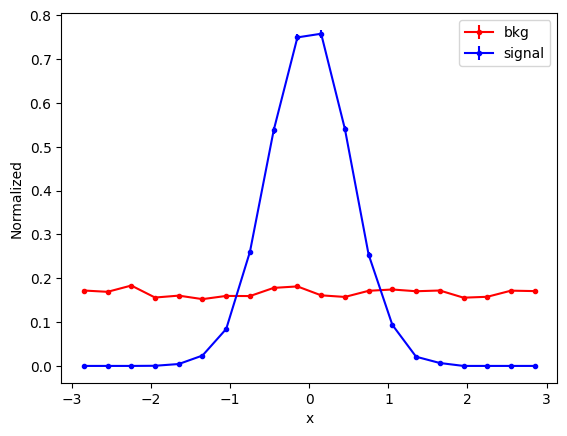

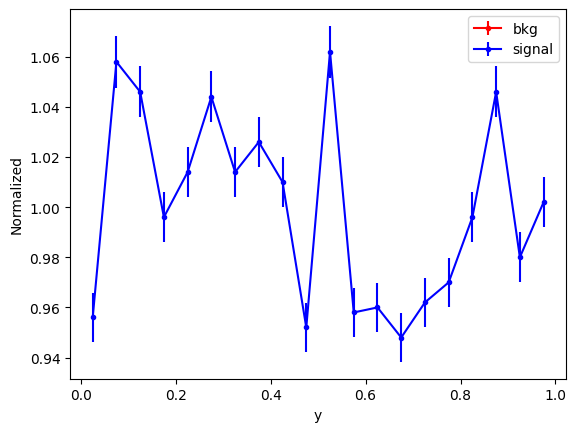

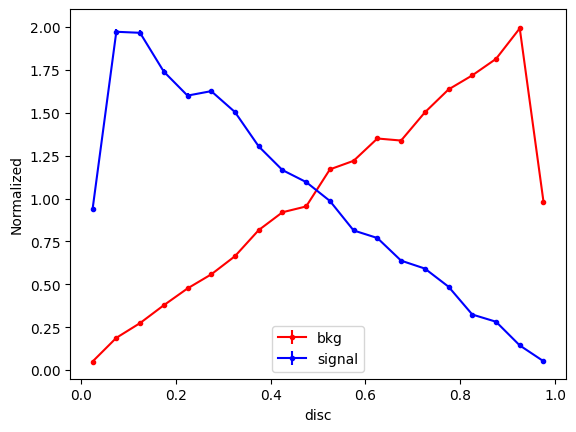

In [289]:
def genData(iNS,iNB):
    sx=np.random.normal(0,0.5,iNS)
    sy=np.random.uniform(0,1,iNS)
    sz=np.random.triangular(0,0.05,1,iNS)
    s=np.vstack([sx,sy,sz])
    
    bx=np.random.uniform(-3,3,iNB)
    by=np.random.uniform(-1,0,iNB)
    bz=np.random.triangular(0.,0.95, 1, iNB)
    b=np.vstack([bx,by,bz])
    return s,b

sig,bkg=genData(10000,10000)
plotHist(sig[0],bkg[0],label="x")
plotHist(sig[1],bkg[1],0,1,label="y")
plotHist(sig[2],bkg[2],0,1,label="disc")

Now lets run some toys of all of this

Fit: 0.750545007782357  rms: 0.5877295588372367
Weak: 1.4565319411338564  rms: 0.9501288393643752


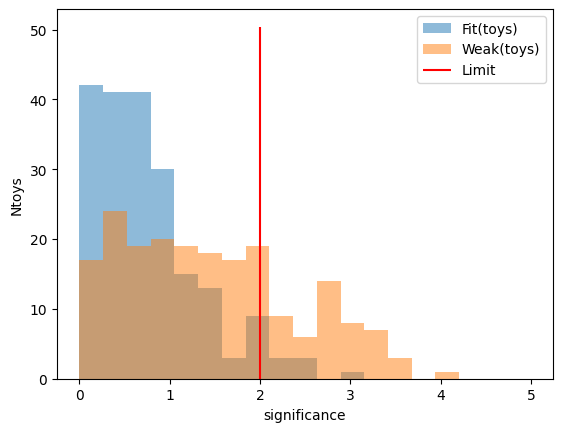

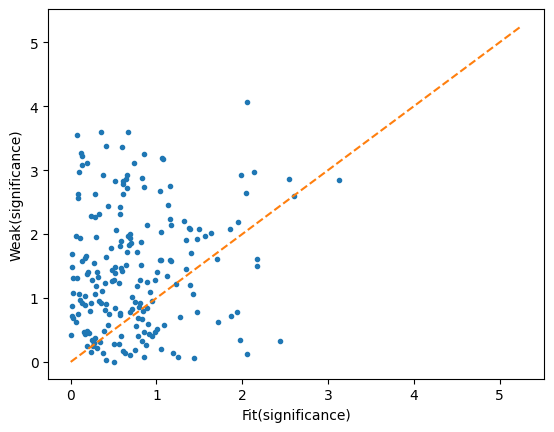

Fit: 64.65498949792408  rms: 0.9473635695699001
Weak: 59.05125499473964  rms: 2.5722328797391683


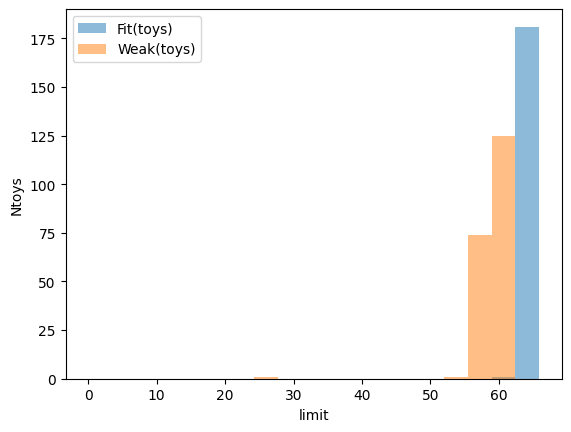

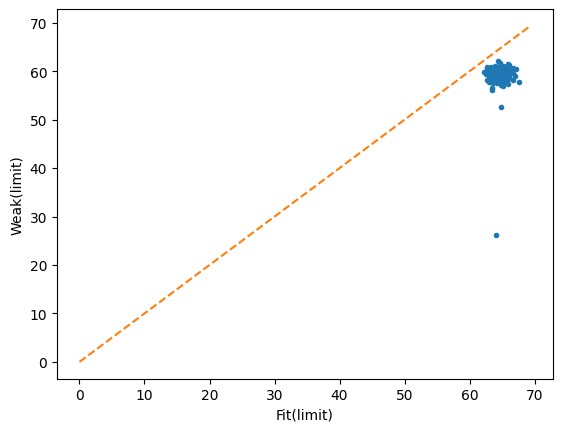

Fit: 4.048957242430907  rms: 36.31774073294985
Weak: 39.79226221663647  rms: 38.0501594845236


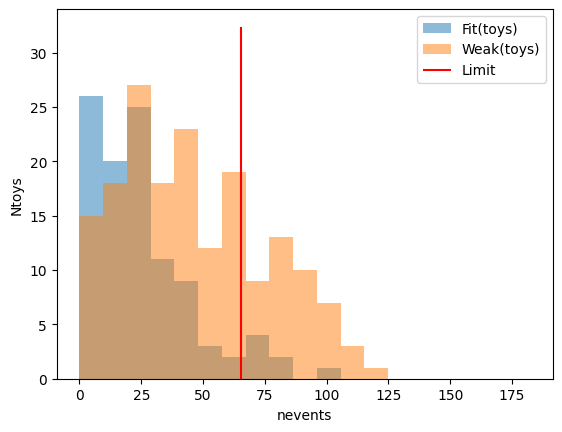

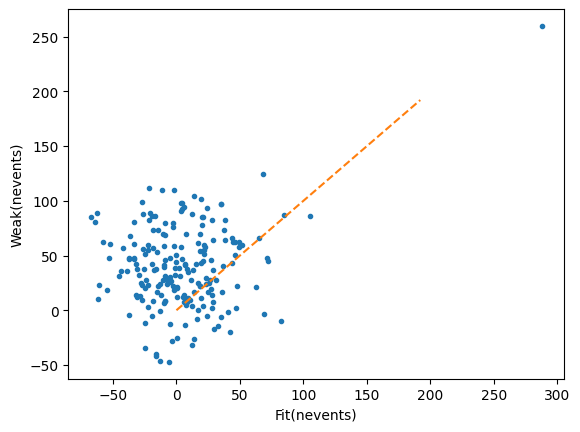

Fit: 1.044776119402985  rms: 4.338074529272091
Weak: 45.16417910447761  rms: 16.342049977296572


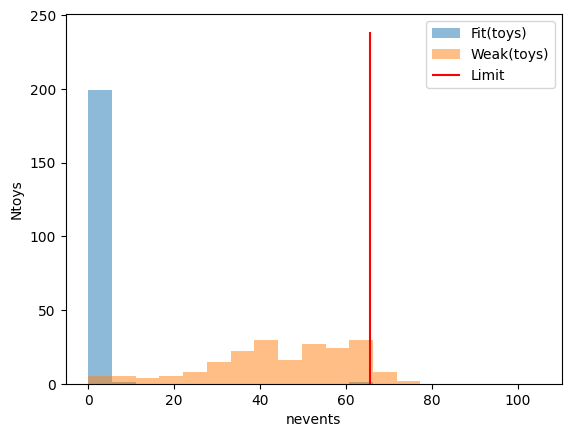

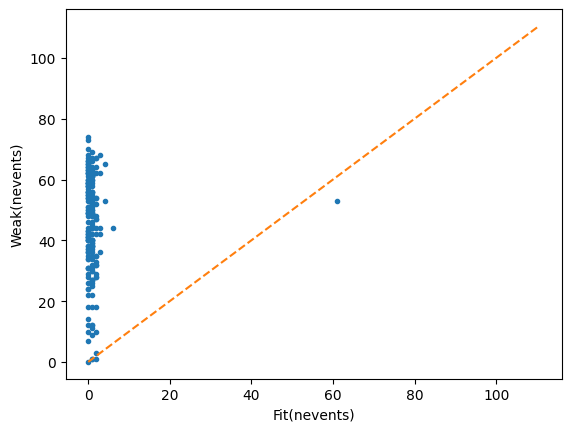

In [429]:
nb=25000
ntoys=50

sigToysTot=np.array([]);  sigWeakToysTot=np.array([]); 
limToysTot=np.array([]);  limWeakToysTot=np.array([]);
ampToysTot=np.array([]);  ampWeakToysTot=np.array([]);
nsigToysTot=np.array([]); nsigWeakToysTot=np.array([]); 

#sigToys,sigWeakToys,limToys,limWeakToys,ampToys,ampWeakToys,nsigToys,nsigWeakToys=runToys(int(0.005*nb),nb,ntoys)
#sigToys1,sigWeakToys1,limToys1,limWeakToys1,ampToys1,ampWeakToys1,nsigToys1,nsigWeakToys1=runToys(int(0.005*nb),nb,ntoys)
#sigToys2,sigWeakToys2,limToys2,limWeakToys2,ampToys2,ampWeakToys2,nsigToys2,nsigWeakToys2=runToys(int(0.005*nb),nb,ntoys)
#sigToys3,sigWeakToys3,limToys3,limWeakToys3,ampToys3,ampWeakToys3,nsigToys3,nsigWeakToys3=runToys(int(0.005*nb),nb,ntoys)
#sigToys4,sigWeakToys4,limToys4,limWeakToys4,ampToys4,ampWeakToys4,nsigToys4,nsigWeakToys4=runToys(int(0.005*nb),nb,ntoys)

sigToysTot  = np.append(sigToys,sigToys1); sigWeakToysTot  = np.append(sigWeakToys,sigWeakToys1); 
limToysTot  = np.append(limToys,limToys1); limWeakToysTot  = np.append(limWeakToys,limWeakToys1); 
ampToysTot  = np.append(ampToys,ampToys1); ampWeakToysTot  = np.append(ampWeakToys,ampWeakToys1); 
nsigToysTot = np.append(nsigToys,nsigToys1); nsigWeakToysTot = np.append(nsigWeakToys,nsigWeakToys1); 

sigToysTot  = np.append(sigToysTot,sigToys2); sigWeakToysTot  = np.append(sigWeakToysTot,sigWeakToys2); 
limToysTot  = np.append(limToysTot,limToys2); limWeakToysTot  = np.append(limWeakToysTot,limWeakToys2); 
ampToysTot  = np.append(ampToysTot,ampToys2); ampWeakToysTot  = np.append(ampWeakToysTot,ampWeakToys2); 
nsigToysTot = np.append(nsigToysTot,nsigToys2); nsigWeakToysTot = np.append(nsigWeakToysTot,nsigWeakToys2); 

sigToysTot  = np.append(sigToysTot,sigToys3); sigWeakToysTot  = np.append(sigWeakToysTot,sigWeakToys3); 
limToysTot  = np.append(limToysTot,limToys3); limWeakToysTot  = np.append(limWeakToysTot,limWeakToys3); 
ampToysTot  = np.append(ampToysTot,ampToys3); ampWeakToysTot  = np.append(ampWeakToysTot,ampWeakToys3); 
nsigToysTot = np.append(nsigToysTot,nsigToys3); nsigWeakToysTot = np.append(nsigWeakToysTot,nsigWeakToys3); 

sigToysTot  = np.append(sigToysTot,sigToys4); sigWeakToysTot  = np.append(sigWeakToysTot,sigWeakToys4); 
limToysTot  = np.append(limToysTot,limToys4); limWeakToysTot  = np.append(limWeakToysTot,limWeakToys4); 
ampToysTot  = np.append(ampToysTot,ampToys4); ampWeakToysTot  = np.append(ampWeakToysTot,ampWeakToys4); 
nsigToysTot = np.append(nsigToysTot,nsigToys4); nsigWeakToysTot = np.append(nsigWeakToysTot,nsigWeakToys4); 


plotToyHist(sigToysTot,sigWeakToysTot,label='significance',iScaleMax=4,iLimit=2.0)
plotToyHist(limToysTot*3.33,limWeakToysTot*3.,label='limit',iScaleMax=4)
plotToyHist(ampToysTot*3.33,ampWeakToysTot*3.,label='nevents',iScaleMax=4,iLimit=np.mean(limWeakToysTot*3.33))
plotToyHist(nsigToysTot,nsigWeakToysTot,label='nevents',iScaleMax=4,iLimit=np.mean(limWeakToysTot*3.33))

Finally, we can do the limit computation, what we will do is scan 50 toys over a variety of signal strengths and we will take the mean and compare to the limit

Fit: 2.7909334635403242  rms: 0.9678988530957782
Weak: 2.2248847483284204  rms: 1.2264144416347216


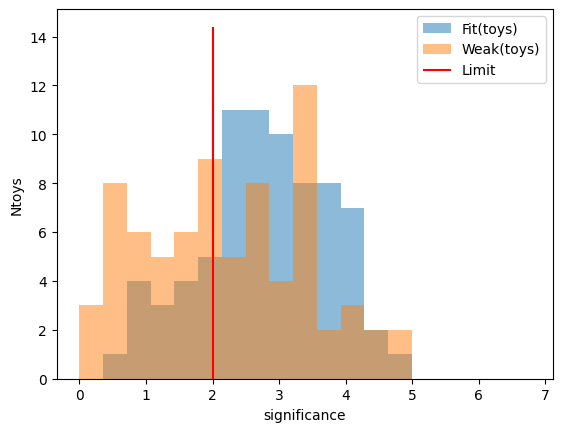

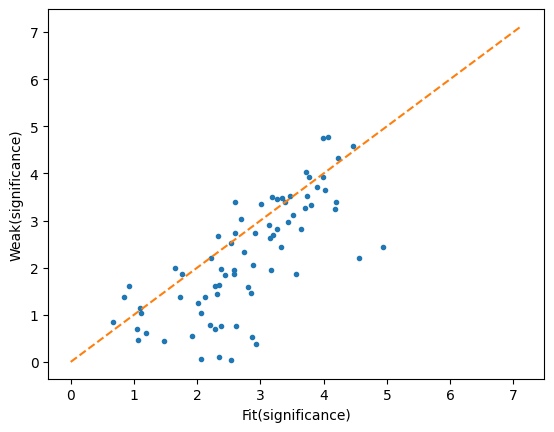

Fit: 67.08572527010286  rms: 0.9709105432996598
Weak: 66.46141895604136  rms: 1.9268609466289712


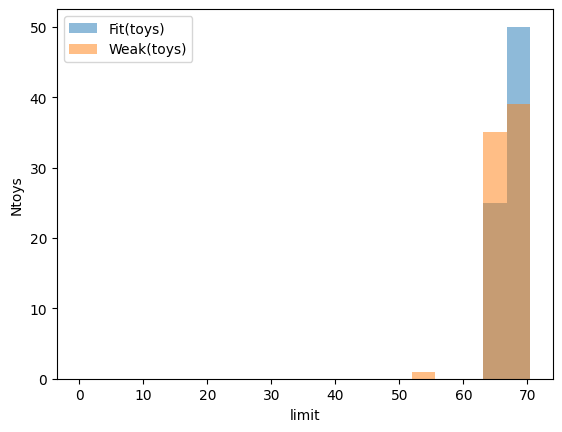

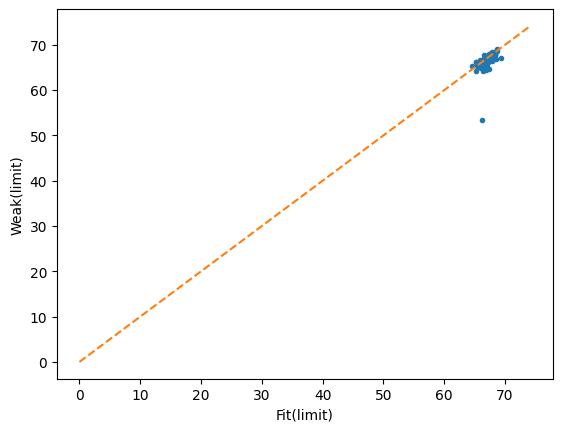

Fit: 94.04386858797398  rms: 33.565802903093875
Weak: 74.60907701115264  rms: 42.289845309342766


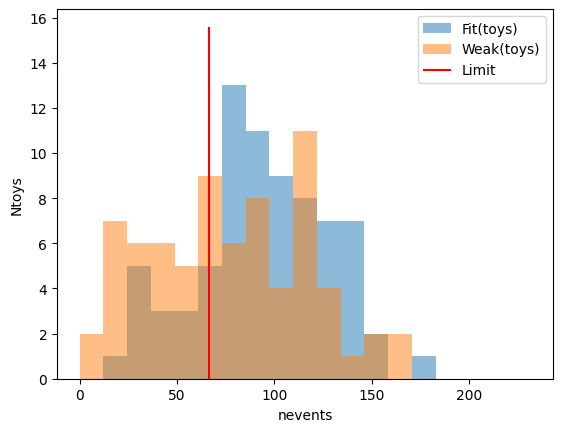

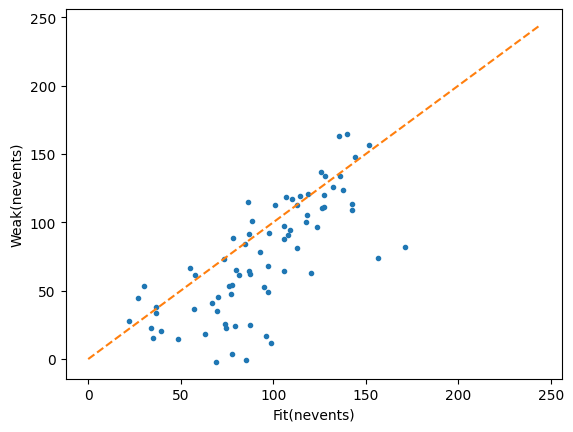

Fit: 91.41333333333333  rms: 6.127736576873679
Weak: 71.36  rms: 19.11832628657645


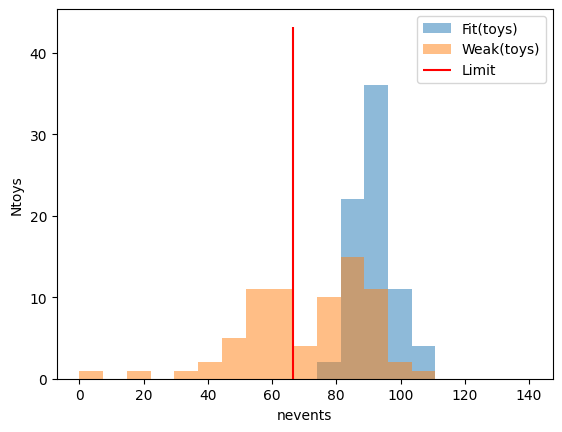

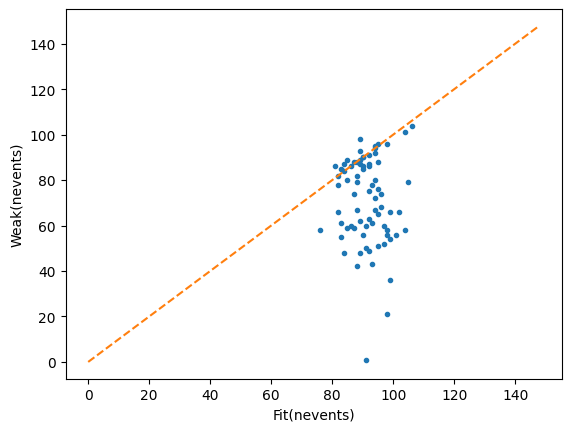

Fit: 3.5716822424153514  rms: 0.893106369111128
Weak: 3.0064335841093763  rms: 1.1996494123148795


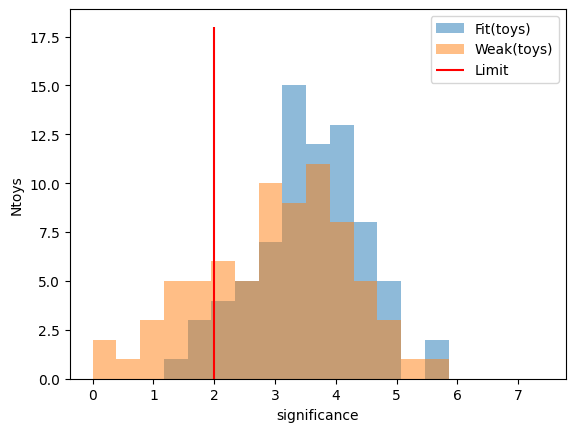

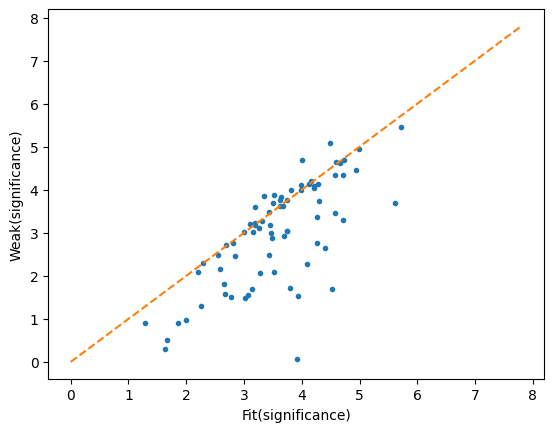

Fit: 67.80569725590986  rms: 0.8895585389760653
Weak: 66.95741138968165  rms: 2.9406847813221564


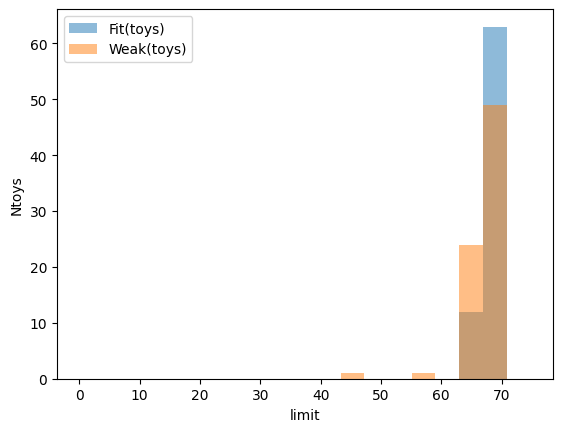

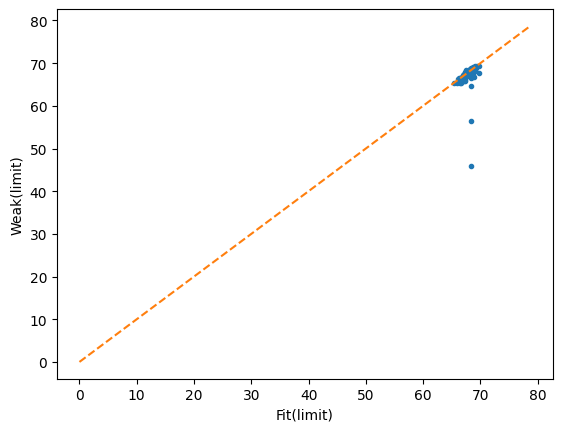

Fit: 121.4793239762797  rms: 31.635805122877823
Weak: 101.39995299365083  rms: 42.08290957558803


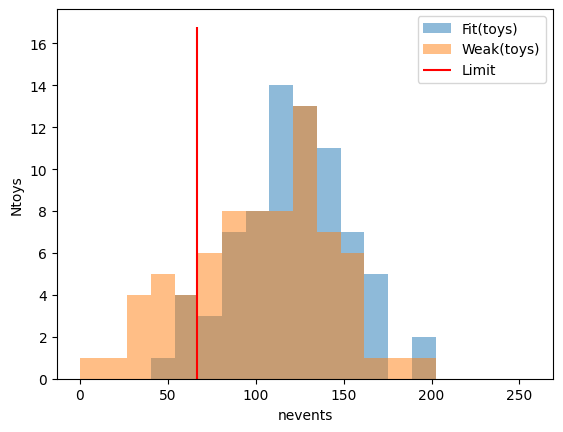

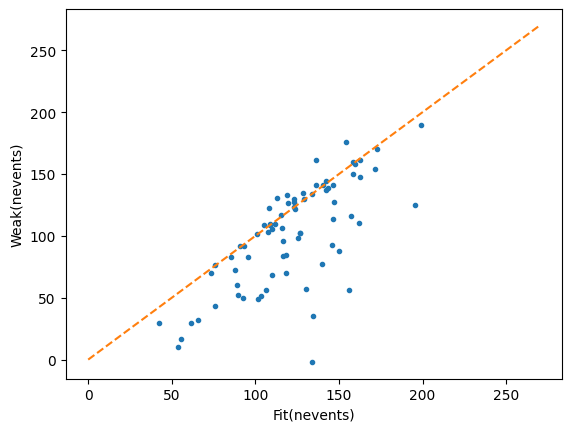

Fit: 120.82666666666667  rms: 7.27438122607155
Weak: 102.94666666666667  rms: 20.79864952880889


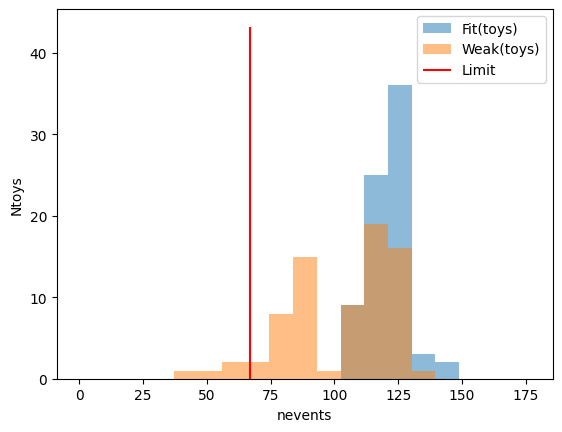

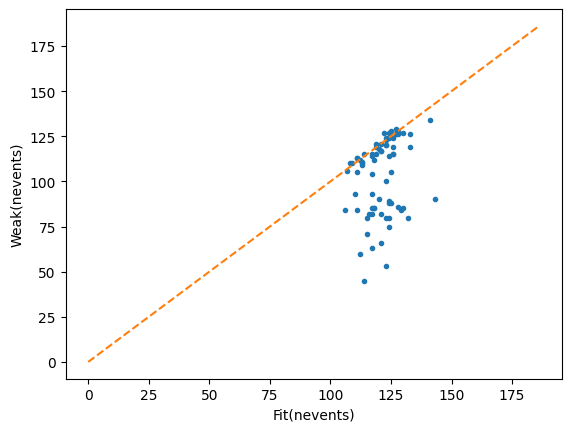

Fit: 4.478726474587957  rms: 0.8600890636370646
Weak: 3.843125622870861  rms: 1.1667852292671368


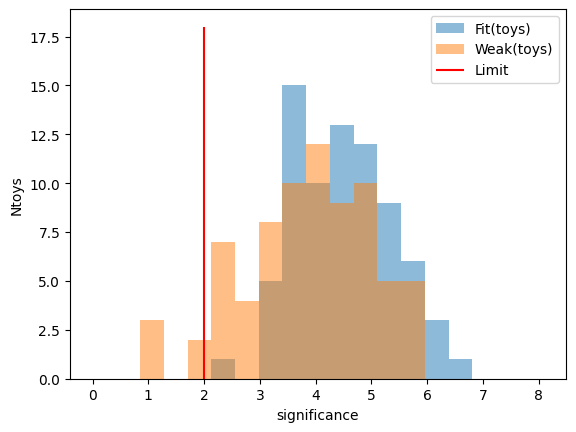

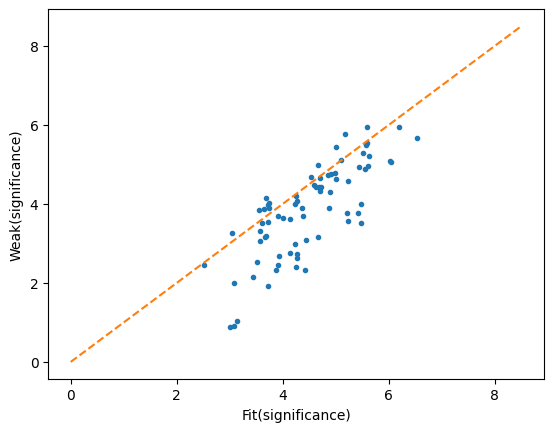

Fit: 68.77962286434992  rms: 0.8401260456763796
Weak: 67.96784753425912  rms: 2.069225238733382


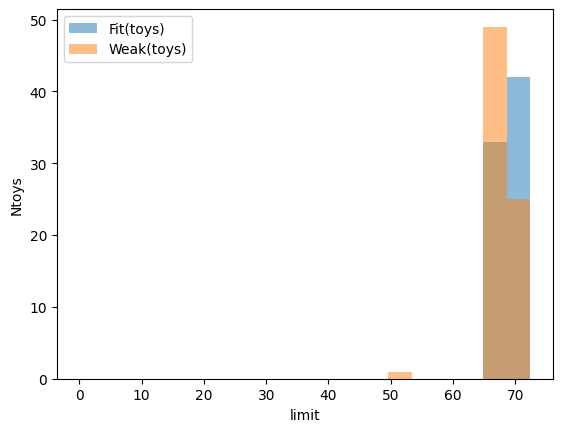

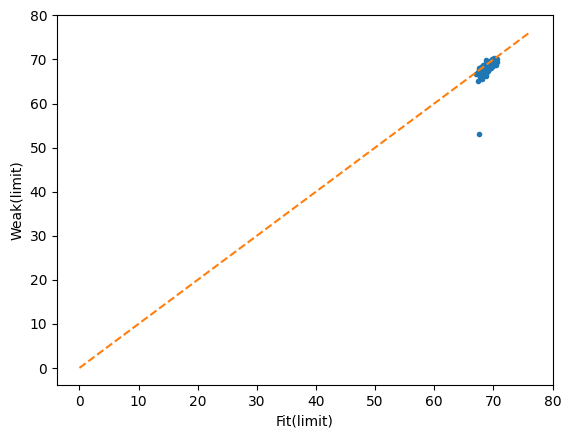

Fit: 154.37307107906096  rms: 31.242925738871996
Weak: 131.22017764840106  rms: 41.60089791973008


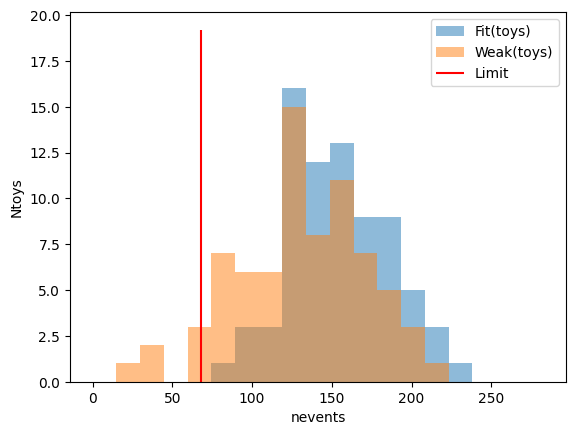

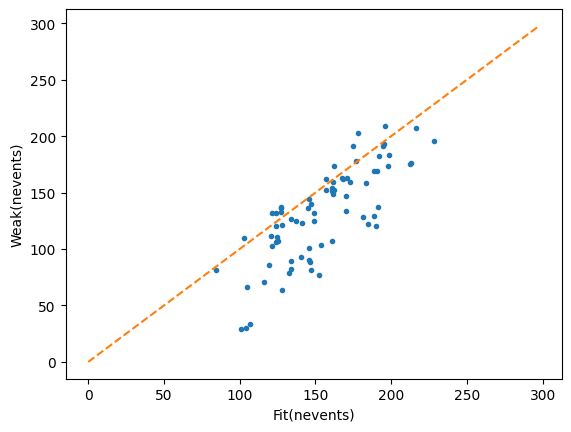

Fit: 150.94666666666666  rms: 10.080864160488535
Weak: 136.53333333333333  rms: 22.244899540244177


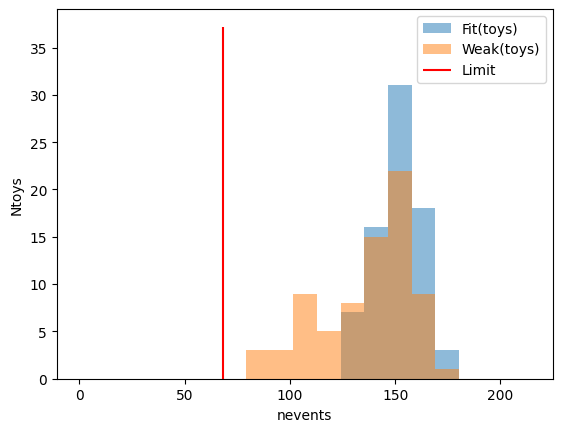

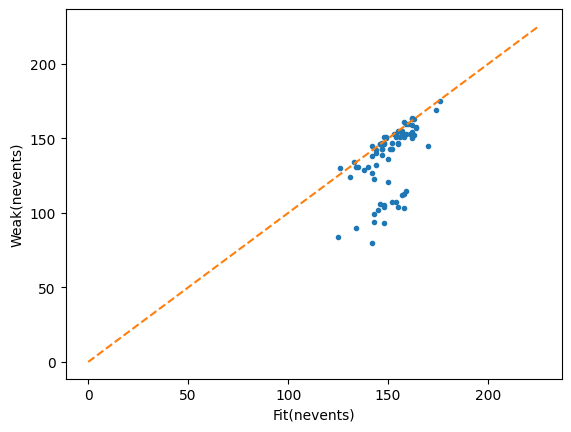

Fit: 5.27378318182745  rms: 0.8194785213927434
Weak: 4.705546200538942  rms: 1.0478263363583475


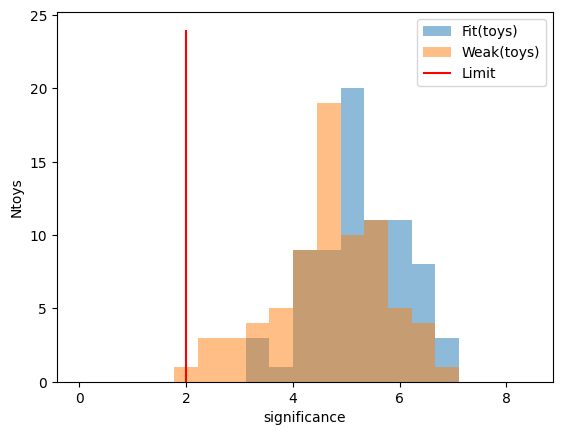

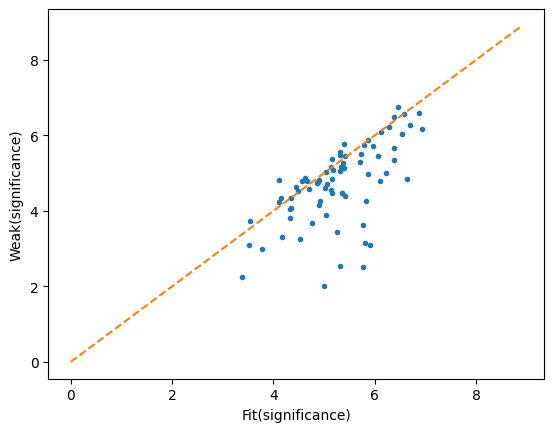

Fit: 69.62962915178865  rms: 0.8461293160558065
Weak: 69.0174518206417  rms: 1.330621310503826


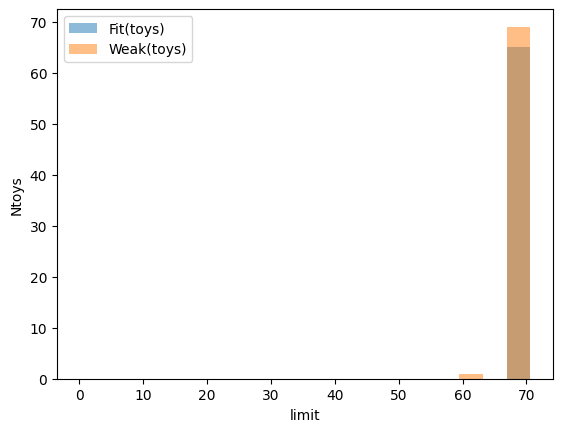

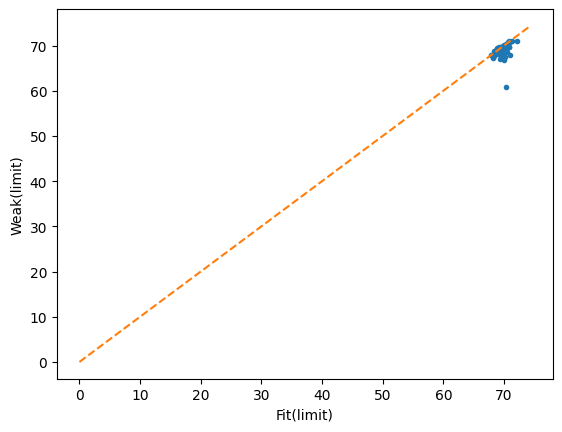

Fit: 183.94977583373966  rms: 30.452579735970275
Weak: 162.97049661660043  rms: 38.3451986828376


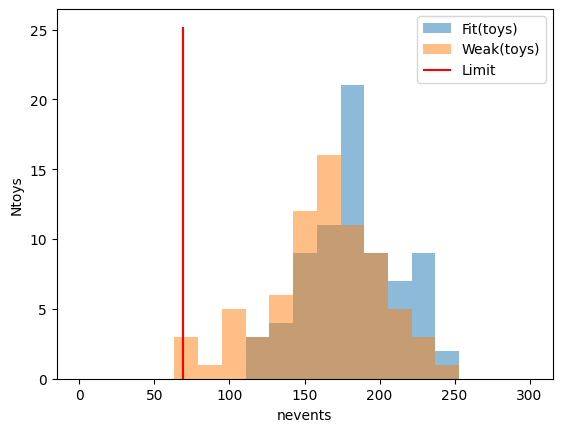

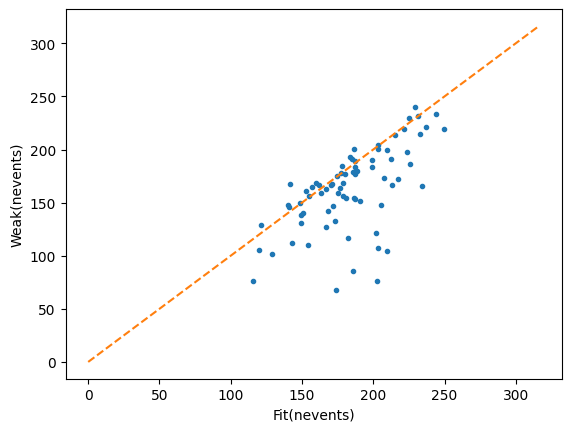

Fit: 180.90666666666667  rms: 8.754691440720354
Weak: 167.12  rms: 22.0090647991534


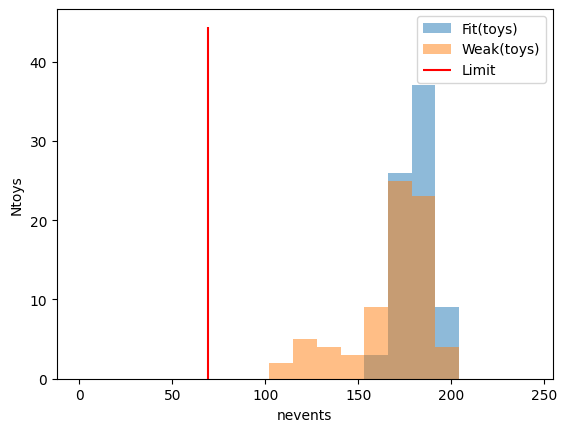

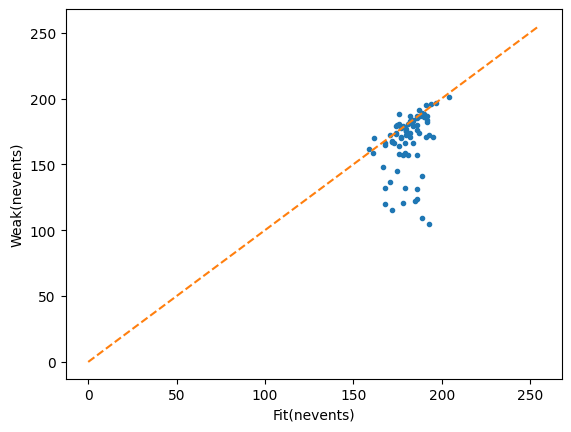

Fit: 1.0831537884067677  rms: 0.819301715086108
Weak: 0.803230872821452  rms: 0.6962855051775579


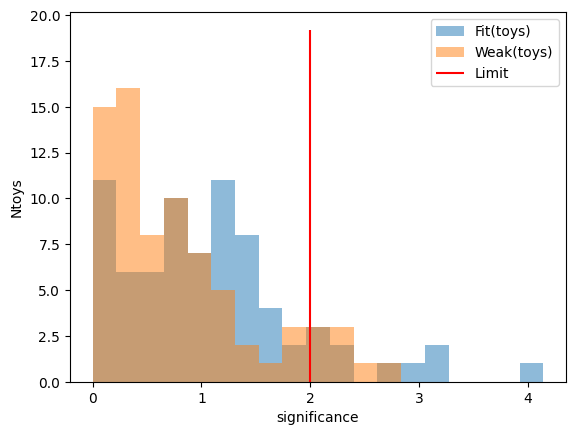

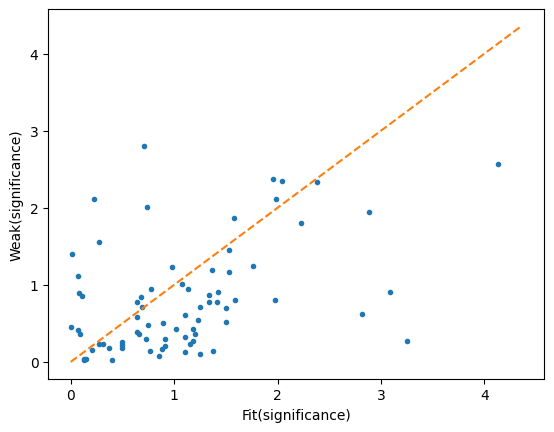

Fit: 65.3785104398987  rms: 1.0903059283640157
Weak: 64.69165799703336  rms: 3.4749994490369303


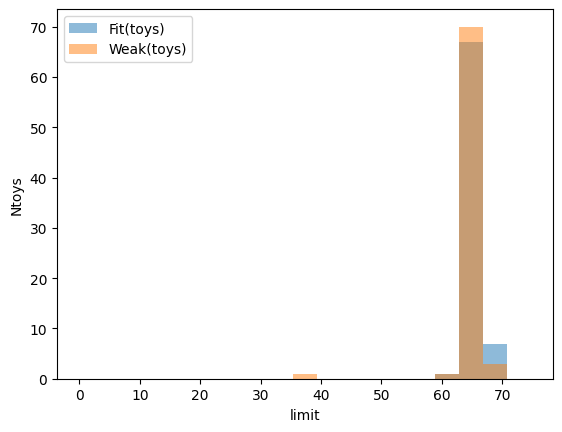

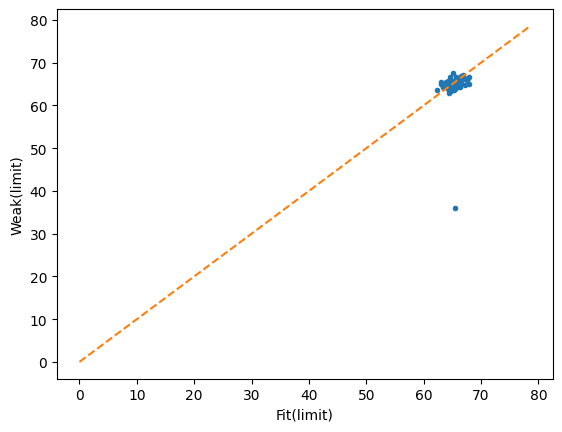

Fit: 28.835738328569825  rms: 34.71680222174774
Weak: 13.45429082767229  rms: 32.43218134059735


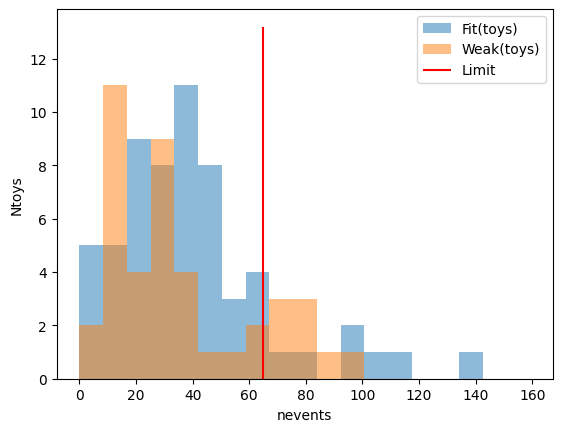

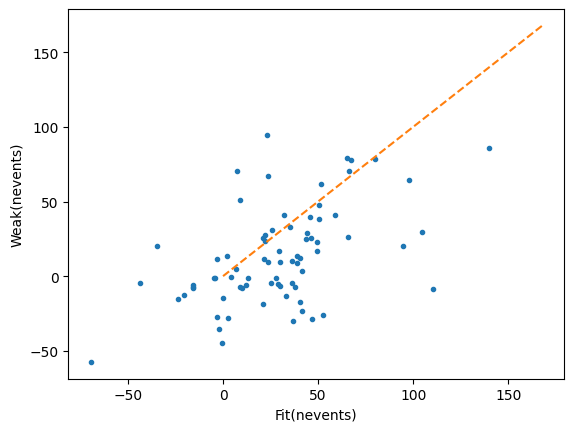

Fit: 31.013333333333332  rms: 4.467641684627609
Weak: 14.746666666666666  rms: 8.929491711302623


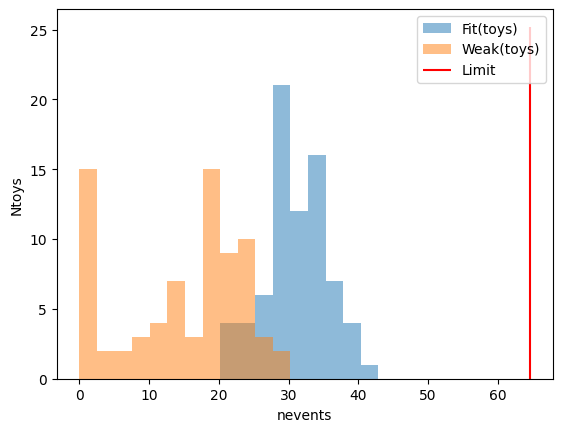

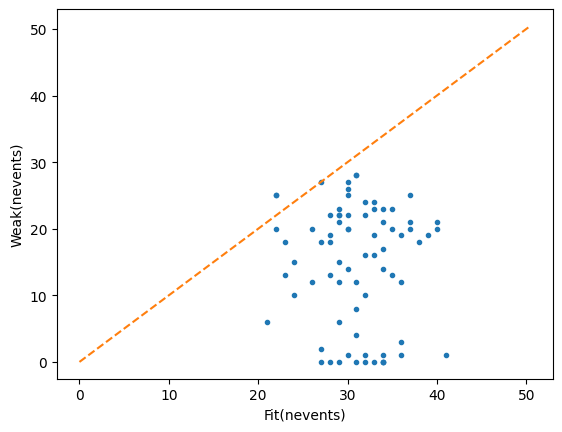

Fit: 1.771342383752417  rms: 0.8899578207584996
Weak: 1.2129947889797117  rms: 0.9467653999689865


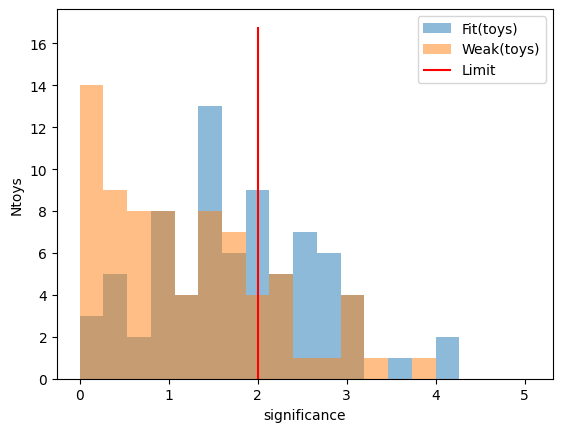

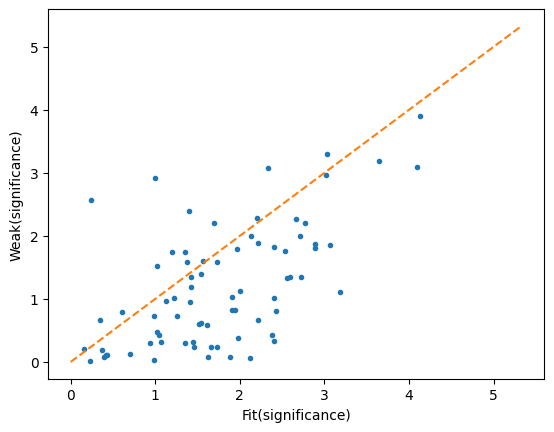

Fit: 66.22932104948372  rms: 0.895072972878627
Weak: 65.4492717807311  rms: 1.2089977382674575


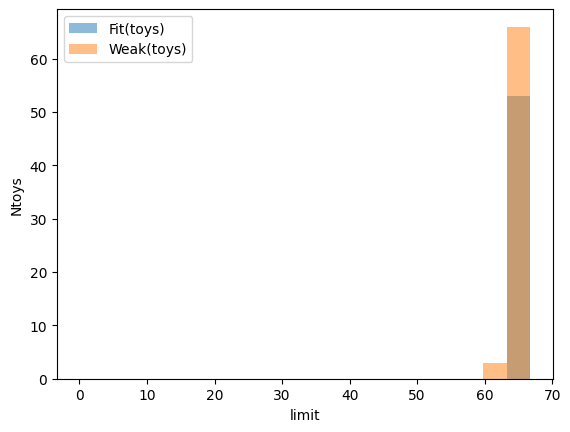

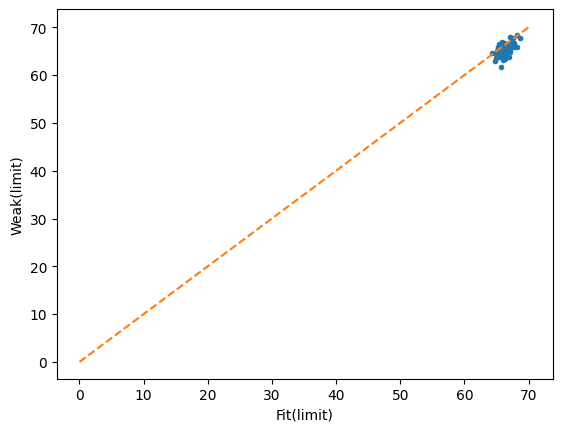

Fit: 58.6516691301005  rms: 31.034355236522835
Weak: 28.50487295362012  rms: 42.34823185063121


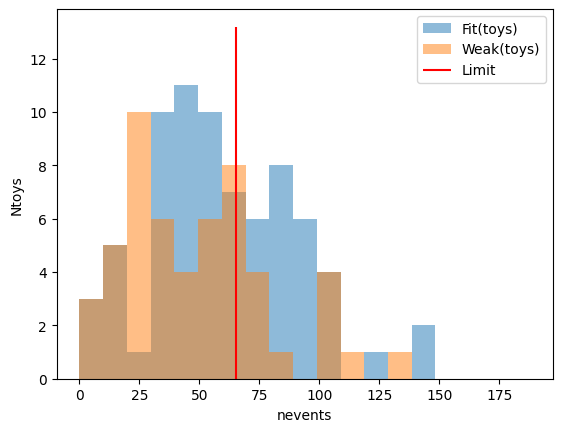

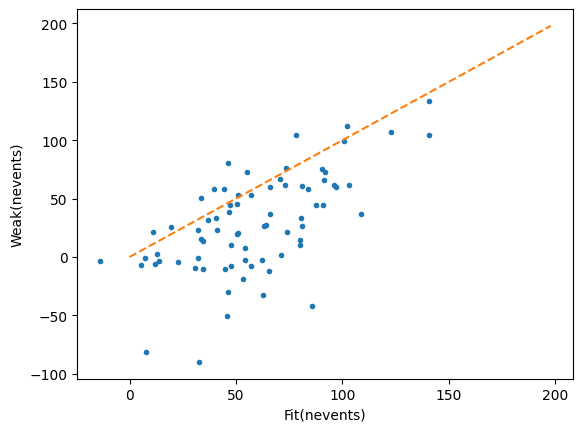

Fit: 62.49333333333333  rms: 5.133870101806456
Weak: 39.906666666666666  rms: 17.804249180712137


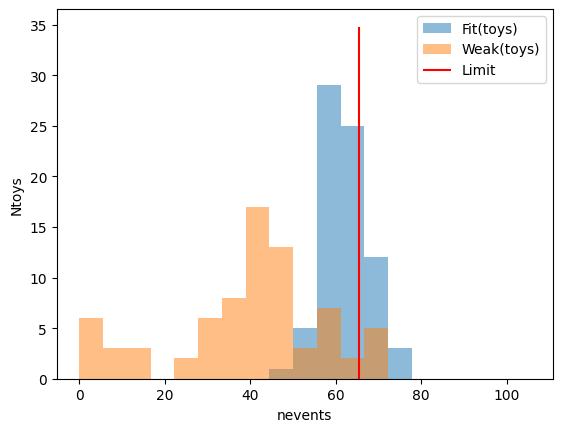

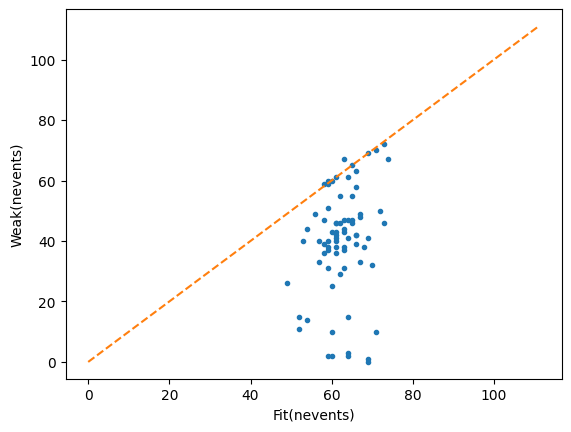

In [520]:
nb=25000
ntoys=25

def genData(iNS,iNB):
    sx=np.random.normal(0,0.5,iNS)
    sy=np.random.uniform(0,1,iNS)
    sz=np.random.triangular(0.,0.95, 1, iNS)
    s=np.vstack([sx,sy,sz])
    
    bx=np.random.uniform(-3,3,iNB)
    by=np.random.uniform(-1,0,iNB)
    bz=np.random.triangular(0,0.05,1,iNB)
    b=np.vstack([bx,by,bz])
    return s,b

sigs=[0.0025,0.005,0.0075,0.01,0.0125,0.015]
#sigToysTotX =np.empty((0,ntoys), float);  sigWeakToysTotX=np.empty((0,ntoys), float); 
#limToysTotX =np.empty((0,ntoys), float);  limWeakToysTotX=np.empty((0,ntoys), float);
#ampToysTotX =np.empty((0,ntoys), float);  ampWeakToysTotX=np.empty((0,ntoys), float);
#nsigToysTotX=np.empty((0,ntoys), float); nsigWeakToysTotX=np.empty((0,ntoys), float); 
#for pSig in sigs:
#    sigToys,sigWeakToys,limToys,limWeakToys,ampToys,ampWeakToys,nsigToys,nsigWeakToys=runToys(int(pSig*nb),nb,ntoys)
#    plotToyHist(sigToys,sigWeakToys,label='significance',iScaleMax=4,iLimit=2.0)
#    plotToyHist(limToys*3.33,limWeakToys*3.33,label='limit',iScaleMax=4)
#    plotToyHist(ampToys*3.33,ampWeakToys*3.33,label='nevents',iScaleMax=4,iLimit=np.mean(limWeakToys*3.33))
#    plotToyHist(nsigToys,nsigWeakToys,label='nevents',iScaleMax=4,iLimit=np.mean(limWeakToys*3.33))
#    sigToysTotX  = np.vstack((sigToysTotX,sigToys)); sigWeakToysTotX    = np.vstack((sigWeakToysTotX,sigWeakToys)); 
#    limToysTotX  = np.vstack((limToysTotX,limToys)); limWeakToysTotX    = np.vstack((limWeakToysTotX,limWeakToys)); 
#    ampToysTotX  = np.vstack((ampToysTotX,ampToys)); ampWeakToysTotX    = np.vstack((ampWeakToysTotX,ampWeakToys)); 
#    nsigToysTotX = np.vstack((nsigToysTotX,nsigToys)); nsigWeakToysTotX = np.vstack((nsigWeakToysTotX,nsigWeakToys)); 

#sigToysTotX2 =np.empty((0,4*ntoys), float);  sigWeakToysTotX2=np.empty((0,4*ntoys), float); 
#limToysTotX2 =np.empty((0,4*ntoys), float);  limWeakToysTotX2=np.empty((0,4*ntoys), float);
#ampToysTotX2 =np.empty((0,4*ntoys), float);  ampWeakToysTotX2=np.empty((0,4*ntoys), float);
#nsigToysTotX2=np.empty((0,4*ntoys), float); nsigWeakToysTotX2=np.empty((0,4*ntoys), float); 
for i0, pSig in enumerate(sigs):
#    if i0 > 1:
#        continue
#    sigToys,sigWeakToys,limToys,limWeakToys,ampToys,ampWeakToys,nsigToys,nsigWeakToys=runToys(int(pSig*nb),nb,ntoys)
#    sigToystmp  = np.append(sigToysTotX[i0], sigToys);  sigWeakToystmp  = np.append(sigWeakToysTotX[i0], sigWeakToys)
#    limToystmp  = np.append(limToysTotX[i0], limToys);  limWeakToystmp  = np.append(limWeakToysTotX[i0], limWeakToys)
#    ampToystmp  = np.append(ampToysTotX[i0], ampToys);  ampWeakToystmp  = np.append(ampWeakToysTotX[i0], ampWeakToys)
#    nsigToystmp = np.append(nsigToysTotX[i0],nsigToys); nsigWeakToystmp = np.append(nsigWeakToysTotX[i0],nsigWeakToys)
#    sigToysTotX2  = np.vstack((sigToysTotX2,sigToystmp)); sigWeakToysTotX2    = np.vstack((sigWeakToysTotX2,sigWeakToystmp)); 
#    limToysTotX2  = np.vstack((limToysTotX2,limToystmp)); limWeakToysTotX2    = np.vstack((limWeakToysTotX2,limWeakToystmp)); 
#    ampToysTotX2  = np.vstack((ampToysTotX2,ampToystmp)); ampWeakToysTotX2    = np.vstack((ampWeakToysTotX2,ampWeakToystmp)); 
#    nsigToysTotX2 = np.vstack((nsigToysTotX2,nsigToystmp)); nsigWeakToysTotX2 = np.vstack((nsigWeakToysTotX2,nsigWeakToystmp)); 
    #if i0 > 1:
    plotToyHist(sigToysTotX2[i0],     sigWeakToysTotX2[i0],label='significance',iScaleMax=4,iLimit=2.0)
    plotToyHist(limToysTotX2[i0]*3.33,limWeakToysTotX2[i0]*3.33,label='limit',iScaleMax=4)
    plotToyHist(ampToysTotX2[i0],     ampWeakToysTotX2[i0], label='nevents',iScaleMax=4,iLimit=np.mean(limWeakToysTotX2[i0]*3.33))
    plotToyHist(nsigToysTotX2[i0],    nsigWeakToysTotX2[i0],label='nevents',iScaleMax=4,iLimit=np.mean(limWeakToysTotX2[i0]*3.33))

    
#plotToyHist(sigToysTot,sigWeakToysTot,label='significance',iScaleMax=4)
#plotToyHist(limToysTot,limWeakToysTot,label='limit',iScaleMax=4)
#plotToyHist(ampToysTot,ampWeakToysTot,label='nevents',iScaleMax=4)
#plotToyHist(nsigToysTot,nsigWeakToysTot,label='nevents',iScaleMax=4,iLimit=np.mean(limWeakToysTot))


Now finally we can compute the expected limit from this scan.

[ 62.5 125.  187.5 250.  312.5 375. ]


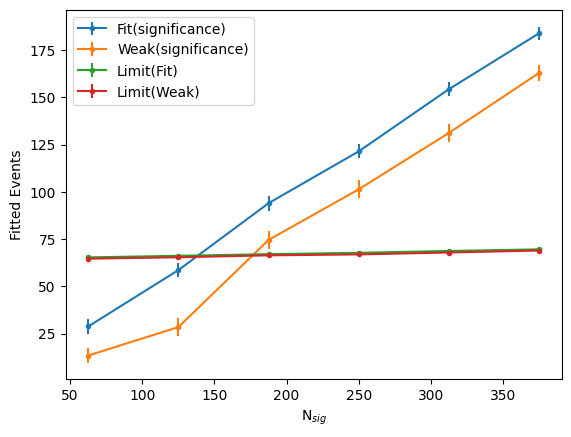

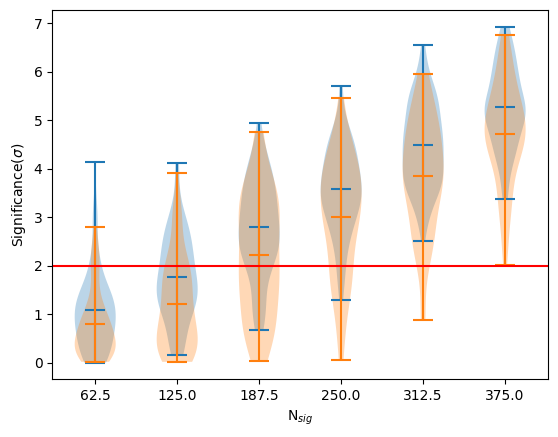

In [518]:
expsig   = np.array([])
expsige  = np.array([])
expWsig   = np.array([])
expWsige  = np.array([])

limsig   = np.array([])
limsige  = np.array([])
limWsig   = np.array([])
limWsige  = np.array([])

fitsig  = []
weaksig = []
#for i0 in range(2):
#    expsig   = np.append(expsig,np.mean(sigToysTotX1[i0]))
#    expsige  = np.append(expsige,np.std(sigToysTotX1[i0]))
for i0 in range(2):
    expsig   = np.append(expsig,np.mean(ampToysTotX2[i0+4]))
    expsige  = np.append(expsige,np.std(ampToysTotX2[i0+4])/np.sqrt(75))
    expWsig   = np.append(expWsig,np.mean(ampWeakToysTotX2[i0+4]))
    expWsige  = np.append(expWsige,np.std(ampWeakToysTotX2[i0+4])/np.sqrt(75))

    limsig    = np.append(limsig,np.mean(limToysTotX2[i0+4]))
    limsige   = np.append(limsige,np.std(limToysTotX2[i0+4])/np.sqrt(75))
    limWsig   = np.append(limWsig,np.mean(limWeakToysTotX2[i0+4]))
    limWsige  = np.append(limWsige,np.std(limWeakToysTotX2[i0+4])/np.sqrt(75))

    #fitsig    = np.vstack((fitsig,sigToysTotX2[i0+4]))
    #weaksig   = np.vstack((weaksig,sigWeakToysTotX2[i0+4]))
    fitsig.append(sigToysTotX2[i0+4])
    weaksig.append(sigWeakToysTotX2[i0+4])
    
for i0 in range(4):
    expsig    = np.append(expsig,np.mean(ampToysTotX2[i0]))
    expsige   = np.append(expsige,np.std(ampToysTotX2[i0])/np.sqrt(75))
    expWsig   = np.append(expWsig,np.mean(ampWeakToysTotX2[i0]))
    expWsige  = np.append(expWsige,np.std(ampWeakToysTotX2[i0])/np.sqrt(75))
 
    limsig    = np.append(limsig,np.mean(limToysTotX2[i0]))
    limsige   = np.append(limsige,np.std(limToysTotX2[i0])/np.sqrt(75))
    limWsig   = np.append(limWsig,np.mean(limWeakToysTotX2[i0]))
    limWsige  = np.append(limWsige,np.std(limWeakToysTotX2[i0])/np.sqrt(75))

    #fitsig    = np.vstack((fitsig,sigToysTotX2[i0,:]))
    #weaksig   = np.vstack((weaksig,sigWeakToysTotX2[i0,:]))
    fitsig.append(sigToysTotX2[i0])
    weaksig.append(sigWeakToysTotX2[i0])

xsigs=(np.array([sigs])*25000.).flatten()
print(xsigs)
plt.errorbar(xsigs,expsig,expsige,label='Fit(significance)',marker='.')
plt.errorbar(xsigs,expWsig,expWsige,label='Weak(significance)',marker='.')
plt.errorbar(xsigs,3.33*limsig,3.33*limsige,label='Limit(Fit)',marker='.')
plt.errorbar(xsigs,3.33*limWsig,3.33*limWsige,label='Limit(Weak)',marker='.')
plt.legend()
plt.xlabel('N$_{sig}$')
plt.ylabel('Fitted Events')
plt.show()

# plot violin plot
plt.violinplot(fitsig,showmeans=True,showmedians=False)
plt.violinplot(weaksig,showmeans=True,showmedians=False)
plt.axhline(y = 2, color = 'r', linestyle = '-')
plt.xticks(np.arange(1, len(xsigs) + 1), xsigs)
#all_data = [np.random.normal(0, std, 100) for std in range(6, 10)]
#print(all_data.shape)
#plt.violinplot(all_data)
plt.ylabel('Significance($\sigma$)')
plt.xlabel('N$_{sig}$')
plt.show()

In [232]:
def convert(NLL):
    p   = 1-stats.chi2.cdf(NLL, 1)
    z   = -1*stats.norm.ppf(p/2.)
    print(z)
    
convert(11.1)
convert(2.7)
convert(2.3)
convert(1.3)
convert(0.2)
convert(0.3)
convert(12.7)
convert(12.8)
convert(172)
convert(170)
convert(2750)
convert(2752)
convert(0.5)
convert(0.3)

3.3316662497915184
1.6431676725154993
1.5165750888103107
1.1401754250991387
0.4472135954999582
0.5477225575051664
3.5637059362410524
3.577708763999662
inf
inf
inf
inf
0.7071067811865477
0.5477225575051664
